In [37]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MultiLabelBinarizer
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from ast import literal_eval
from tqdm import tqdm
import re

from collections import Counter
from collections import defaultdict

In [38]:
#df_copy = pd.read_csv('data/stage_3_df_100s_50p_5.csv')
df_copy = pd.read_csv('data/stage_3_df_cluster_vac_to_model_4.csv')


In [39]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14975 entries, 0 to 14974
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   position                  14975 non-null  object 
 1   date                      14975 non-null  object 
 2   vacancy                   14975 non-null  object 
 3   company                   14975 non-null  object 
 4   city                      14975 non-null  object 
 5   experience                14975 non-null  object 
 6   employment                14975 non-null  object 
 7   schedule                  14975 non-null  object 
 8   salary from               14975 non-null  float64
 9   salary to                 14975 non-null  float64
 10  currency                  14968 non-null  object 
 11  skills                    14975 non-null  object 
 12  url                       14975 non-null  object 
 13  ID                        14975 non-null  float64
 14  countr

In [40]:
df_copy = df_copy.drop(['industry','level_copy', 'is_it','skills_list', 'skills_clean',
                        'skills_llm','vacancy_info','experience level','contact', 'contacts', 'education', 'benefits', 
                        'requirements', 'responsibilities', 'period of pay', 'text',
                        'ID', 'url', 'skills_count','currency', 'skills_new', 'vacancy_norm'], axis = 1)

In [41]:
# подготовка данных к обучению

df_train_result = df_copy[(df_copy['country'] == 'Россия') ][['salary from norm',
                                                              'salary to norm', 
                                                              'position', 
                                                              'experience_norm', 
                                                               'skills_clean_norm', # 'skills_clean_norm','skills_processed, 'skills_manu'
                                                              'schedule','employment', 'vacancy it',
                                                               #'vacancy_norm_llm_check_1', 'vacancy it','vacancy_manu','vacancy_norm_2', 'vacancy_manu'
                                                              'level',
                                                              'region']]

df_train_result = df_train_result.dropna(subset=['salary from norm', 'salary to norm'], how='any') # 

df_train_result.rename(columns={'skills_clean_norm': 'skills',
                                'experience_norm':'experience',
                                'vacancy it':'vacancy'}, inplace=True)

df_train_result['skills'] = df_train_result['skills'].apply(literal_eval)

df_train_result.rename(columns={
    'salary from norm': 'salary from',
    'salary to norm': 'salary to'
}, inplace=True)

#### Далееек код O.K. по очистке и нормализации скилов

In [42]:
# Дополнительная предварительная очистка (исправленная версия)
def clean_skills(skill_str):
    # Сначала преобразуем в строку, затем очищаем и приводим к нижнему регистру
    cleaned = re.sub(r'[^\w\s,;/]', '', str(skill_str))
    return cleaned.lower()

# Применяем очистку
df_train_result['skills_ok'] = df_train_result['skills'].apply(clean_skills)

In [43]:
import re
import ast
from typing import Union, List, Dict, Set, Optional, Any
from collections import defaultdict
class FinalSkillNormalizer:
    def __init__(self):
        """Инициализация нормализатора с загрузкой всех правил"""
        self._init_skill_mappings()
        self._init_hierarchy()
        self._init_auto_categorization_rules()
        self._init_stop_skills()
        self._init_special_cases()
        self._build_reverse_index()
        self._init_skill_normalization_rules()

    def _init_skill_normalization_rules(self):
        """Дополнительные правила для нормализации составных навыков"""
        self.skill_normalization_rules = [
            # Разделение навыков с разделителями
            (r'[,;/\\&+]', lambda x: [s.strip() for s in re.split(r'[,;/\\&+]', x) if s.strip()]),
            
            # Обработка версий и скобок
            (r'\([^)]*\)', ''),  # Удаление всего в скобках
            (r'[\d.]+', ''),     # Удаление версий
            
            # Нормализация конкретных случаев
            (r'excel\s*(power\s*(query|pivot))', 'Excel Power Tools'),
            (r'power\s*(bi|query|pivot)', lambda m: f"Power {m.group(1).title()}"),
            (r'html\s*/?\s*css', 'HTML/CSS'),
            (r'sql\s*\w+', 'SQL'),
            (r'python\s*\w+', 'Python'),
            (r'js\b', 'JavaScript'),
            (r'базы?\s*данных', 'Databases')
        ]

    def normalize_skill_item(self, skill: str) -> List[str]:
        """Нормализует отдельный навык, возможно разбивая его на несколько"""
        if not skill or str(skill).lower() in self.stop_skills:
            return []
            
        # Применяем специальные случаи в первую очередь
        skill = self._handle_special_cases(skill.lower())
        
        # Применяем правила нормализации
        for pattern, replacement in self.skill_normalization_rules:
            if isinstance(replacement, str):
                skill = re.sub(pattern, replacement, skill, flags=re.IGNORECASE)
            else:
                skill = replacement(skill)
        
        # Если получили список - нормализуем каждый элемент
        if isinstance(skill, list):
            return [s for item in skill for s in self.normalize_skill_item(item)]
            
        # Базовая очистка
        skill = skill.strip(" .,!?()[]{}«»\"'")
        
        # Применяем маппинг
        normalized = self.skill_map.get(skill, skill.title())
        
        # Дополнительная очистка
        normalized = re.sub(r'\s+', ' ', normalized).strip()
        
        return [normalized] if normalized else []

    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Улучшенная нормализация с обработкой составных навыков"""
        if skill_input is None:
            return []
            
        if isinstance(skill_input, str) and not skill_input.strip():
            return []
            
        # Преобразование ввода в список
        if isinstance(skill_input, str):
            try:
                skills = ast.literal_eval(skill_input) if (
                    '[' in skill_input and ']' in skill_input
                ) else [skill_input.strip()]
            except (ValueError, SyntaxError):
                skills = [skill_input.strip()]
        elif isinstance(skill_input, list):
            skills = skill_input
        else:
            return []
            
        # Нормализация каждого навыка с разбивкой
        normalized = set()
        for skill in skills:
            if not skill or str(skill).lower() in {'nan', 'none', 'null'}:
                continue
                
            # Нормализуем и добавляем все части
            for item in self.normalize_skill_item(skill):
                if item and item not in self.stop_skills:
                    normalized.add(item)
                    
        return sorted(normalized) if normalized else []

    def _init_stop_skills(self):
        """Инициализация списка стоп-слов для игнорирования"""
        self.stop_skills = {
            'nan', 'none', 'нет', 'other', 'другое', 'иное', 
            'разное', 'прочее', 'разные', 'etc', 'и др', 'и другие',
            '', 'не указано', 'not specified'
        }    

    def _init_skill_mappings(self):
        """Полный маппинг 200+ навыков из анализа"""
        self.skill_map = {
            # 1С экосистема (45 навыков)
            '1с': '1C', '1c': '1C',
            '1с программирование': '1C Development',
            '1c программирование': '1C Development',
            '1с: предприятие 8': '1C Enterprise 8',
            '1c: предприятие 8': '1C Enterprise 8',
            '1с:erp': '1C ERP', '1c:erp': '1C ERP',
            '1с:бухгалтерия': '1C Accounting',
            '1с:документооборот': '1C Document Management',
            '1с:зуп': '1C ZUP', '1с:управление торговлей': '1C Trade Management',
            '1с:розница': '1C Retail', '1с:wms': '1C WMS',
            '1с:управление холдингом': '1C Holding Management',
            '1с:кадры': '1C HR', '1с:зарплата': '1C Payroll',
            '1с:документооборот корп': '1C Corporate Document Management',
            '1с:erp 2.5': '1C ERP 2.5', '1с:erp 2.4': '1C ERP 2.4',
            '1с:комплексная автоматизация': '1C Comprehensive Automation',
            '1с:библиотека стандартов': '1C Standards Library',
            '1с:доп': '1C Additional', '1с:документы': '1C Documents',
            '1с:отчеты': '1C Reports', '1с:аналитика': '1C Analytics',
            '1с:консоль запросов': '1C Query Console',
            '1с:обмен данными': '1C Data Exchange',
            '1с:конфигуратор': '1C Configurator',
            '1с:управляемые формы': '1C Managed Forms',
            '1с:скд': '1C Data Composition System',
            '1с:web-сервисы': '1C Web Services',
            '1с:http-сервисы': '1C HTTP Services',
            '1с:rest api': '1C REST API',
            '1с:мобильная платформа': '1C Mobile Platform',
            '1с:лицензии': '1C Licenses', '1с:хакинг': '1C Hacking',
            '1с:оптимизация': '1C Optimization',
            '1с:миграция данных': '1C Data Migration',
            '1с:интеграция': '1C Integration',
            '1с:асинхронные вызовы': '1C Async Calls',
            '1с:расширения': '1C Extensions',
            '1с:внешние компоненты': '1C External Components',
            '1с:отчеты и обработки': '1C Reports and Processing',
            '1с:анализ производительности': '1C Performance Analysis',
            '1с:администрирование': '1C Administration',
            '1с:кластер серверов': '1C Server Cluster',
            '1с:рабочие процессы': '1C Workflows',
            
            # Базы данных (32 навыка)
            'postgresql': 'PostgreSQL', 'postgres': 'PostgreSQL',
            'mysql': 'MySQL', 'mariadb': 'MariaDB',
            'ms sql': 'SQL Server', 'microsoft sql server': 'SQL Server',
            'oracle': 'Oracle', 'oracle db': 'Oracle',
            'sqlite': 'SQLite', 'firebird': 'Firebird',
            'greenplum': 'Greenplum', 'clickhouse': 'ClickHouse',
            'mongodb': 'MongoDB', 'redis': 'Redis',
            'elasticsearch': 'Elasticsearch', 'cassandra': 'Cassandra',
            'hbase': 'HBase', 'hive': 'Hive',
            'sql': 'SQL', 'pl/sql': 'PL/SQL',
            't-sql': 'T-SQL', 'nosql': 'NoSQL',
            'реляционные бд': 'Relational DB', 'sql запросы': 'SQL Queries',
            'оптимизация запросов': 'Query Optimization',
            'индексы': 'Indexes', 'транзакции': 'Transactions',
            'репликация': 'Replication', 'партиционирование': 'Partitioning',
            'бэкапы': 'Backups', 'восстановление': 'Recovery',
            'настройка бд': 'DB Tuning', 'мониторинг бд': 'DB Monitoring',
            
            # Программирование (40 навыков)
            'python': 'Python', 'python 3': 'Python',
            'java': 'Java', 'java ee': 'Java EE',
            'c#': 'C#', 'c++': 'C++',
            'php': 'PHP', 'php 7': 'PHP', 'php 8': 'PHP',
            'javascript': 'JavaScript', 'js': 'JavaScript',
            'typescript': 'TypeScript', 'ts': 'TypeScript',
            'go': 'Go', 'golang': 'Go',
            'scala': 'Scala', 'kotlin': 'Kotlin',
            'ruby': 'Ruby', 'swift': 'Swift',
            'objective-c': 'Objective-C', 'rust': 'Rust',
            'delphi': 'Delphi', 'pascal': 'Pascal',
            'html': 'HTML', 'css': 'CSS',
            'html5': 'HTML5', 'css3': 'CSS3',
            'sass': 'SASS', 'less': 'LESS',
            'web assembly': 'WebAssembly', 'wasm': 'WebAssembly',
            'bash': 'Bash', 'powershell': 'PowerShell',
            'регулярные выражения': 'Regular Expressions',
            'алгоритмы': 'Algorithms', 'структуры данных': 'Data Structures',
            'ооп': 'OOP', 'функциональное программирование': 'Functional Programming',
            'рефакторинг': 'Refactoring', 'паттерны проектирования': 'Design Patterns',
            'чистый код': 'Clean Code', 'тестирование кода': 'Code Testing',
            
            # DevOps (28 навыков)
            'docker': 'Docker', 'kubernetes': 'Kubernetes',
            'openshift': 'OpenShift', 'rancher': 'Rancher',
            'ci/cd': 'CI/CD', 'jenkins': 'Jenkins',
            'gitlab ci': 'GitLab CI', 'github actions': 'GitHub Actions',
            'teamcity': 'TeamCity', 'bamboo': 'Bamboo',
            'ansible': 'Ansible', 'terraform': 'Terraform',
            'puppet': 'Puppet', 'chef': 'Chef',
            'vagrant': 'Vagrant', 'packer': 'Packer',
            'prometheus': 'Prometheus', 'grafana': 'Grafana',
            'zabbix': 'Zabbix', 'elk': 'ELK',
            'splunk': 'Splunk', 'new relic': 'New Relic',
            'datadog': 'Datadog', 'nagios': 'Nagios',
            'мониторинг': 'Monitoring', 'логирование': 'Logging',
            'оркестрация': 'Orchestration', 'инфраструктура как код': 'Infrastructure as Code',
            
            # Системное администрирование (35 навыков)
            'linux': 'Linux', 'ubuntu': 'Ubuntu',
            'centos': 'CentOS', 'debian': 'Debian',
            'red hat': 'Red Hat', 'suse': 'SUSE',
            'windows server': 'Windows Server', 'active directory': 'Active Directory',
            'dns': 'DNS', 'dhcp': 'DHCP',
            'tcp/ip': 'TCP/IP', 'http': 'HTTP',
            'https': 'HTTPS', 'ssl': 'SSL',
            'tls': 'TLS', 'vpn': 'VPN',
            'ldap': 'LDAP', 'kerberos': 'Kerberos',
            'samba': 'Samba', 'nfs': 'NFS',
            'iscsi': 'iSCSI', 'raid': 'RAID',
            'lvm': 'LVM', 'zfs': 'ZFS',
            'btrfs': 'BTRFS', 'виртуализация': 'Virtualization',
            'vmware': 'VMware', 'hyper-v': 'Hyper-V',
            'proxmox': 'Proxmox', 'kvm': 'KVM',
            'xen': 'Xen', 'бэкапы': 'Backups',
            'восстановление данных': 'Data Recovery', 'безопасность': 'Security',
            'аудит': 'Audit',
            
            # Веб-разработка (25 навыков)
            'django': 'Django', 'flask': 'Flask',
            'fastapi': 'FastAPI', 'spring': 'Spring',
            'laravel': 'Laravel', 'symfony': 'Symfony',
            'ruby on rails': 'Ruby on Rails', 'express': 'Express',
            'react': 'React', 'angular': 'Angular',
            'vue': 'Vue', 'svelte': 'Svelte',
            'node.js': 'Node.js', 'nest.js': 'NestJS',
            'rest api': 'REST API', 'graphql': 'GraphQL',
            'soap': 'SOAP', 'grpc': 'gRPC',
            'websocket': 'WebSocket', 'webpack': 'Webpack',
            'gulp': 'Gulp', 'parcel': 'Parcel',
            'веб-разработка': 'Web Development', 'веб-приложения': 'Web Applications',
            'pwa': 'PWA'
        }

    def _init_hierarchy(self):
        """Полная иерархия навыков"""
        self.skill_hierarchy = {
            '1C Ecosystem': {
                'Platform': {
                    '1C', '1C Enterprise 8', '1C ERP', '1C ERP 2.5', '1C ERP 2.4',
                    '1C Accounting', '1C Document Management', '1C ZUP',
                    '1C Trade Management', '1C Retail', '1C WMS',
                    '1C Holding Management', '1C HR', '1C Payroll',
                    '1C Corporate Document Management', '1C Comprehensive Automation',
                    '1C Standards Library'
                },
                'Development': {
                    '1C Development', '1C Data Composition System', '1C Managed Forms',
                    '1C Query Console', '1C Web Services', '1C HTTP Services',
                    '1C REST API', '1C Mobile Platform', '1C Extensions',
                    '1C External Components', '1C Reports and Processing'
                },
                'Administration': {
                    '1C Administration', '1C Server Cluster', '1C Performance Analysis',
                    '1C Licenses', '1C Optimization', '1C Data Migration',
                    '1C Integration', '1C Workflows'
                }
            },
            'Databases': {
                'SQL Databases': {
                    'PostgreSQL', 'MySQL', 'MariaDB', 'SQL Server', 'Oracle',
                    'SQLite', 'Firebird', 'Greenplum', 'ClickHouse', 'PL/SQL', 'T-SQL'
                },
                'NoSQL Databases': {
                    'MongoDB', 'Redis', 'Elasticsearch', 'Cassandra', 'HBase', 'Hive'
                },
                'Database Tools': {
                    'SQL', 'SQL Queries', 'Query Optimization', 'Indexes',
                    'Transactions', 'Replication', 'Partitioning', 'Backups',
                    'Recovery', 'DB Tuning', 'DB Monitoring'
                }
            },
            'Programming': {
                'Languages': {
                    'Python', 'Java', 'Java EE', 'C#', 'C++', 'PHP', 'JavaScript',
                    'TypeScript', 'Go', 'Scala', 'Kotlin', 'Ruby', 'Swift',
                    'Objective-C', 'Rust', 'Delphi', 'Pascal', 'Bash', 'PowerShell'
                },
                'Web Technologies': {
                    'HTML', 'CSS', 'HTML5', 'CSS3', 'SASS', 'LESS', 'WebAssembly'
                },
                'Programming Concepts': {
                    'Algorithms', 'Data Structures', 'OOP', 'Functional Programming',
                    'Refactoring', 'Design Patterns', 'Clean Code', 'Code Testing',
                    'Regular Expressions'
                }
            },
            'DevOps': {
                'Containerization': {
                    'Docker', 'Kubernetes', 'OpenShift', 'Rancher'
                },
                'CI/CD': {
                    'CI/CD', 'Jenkins', 'GitLab CI', 'GitHub Actions', 'TeamCity', 'Bamboo'
                },
                'Infrastructure': {
                    'Ansible', 'Terraform', 'Puppet', 'Chef', 'Vagrant', 'Packer'
                },
                'Monitoring': {
                    'Prometheus', 'Grafana', 'Zabbix', 'ELK', 'Splunk', 'New Relic',
                    'Datadog', 'Nagios', 'Monitoring', 'Logging'
                },
                'DevOps Concepts': {
                    'Orchestration', 'Infrastructure as Code'
                }
            },
            'System Administration': {
                'Operating Systems': {
                    'Linux', 'Ubuntu', 'CentOS', 'Debian', 'Red Hat', 'SUSE',
                    'Windows Server'
                },
                'Network': {
                    'Active Directory', 'DNS', 'DHCP', 'TCP/IP', 'HTTP', 'HTTPS',
                    'SSL', 'TLS', 'VPN', 'LDAP', 'Kerberos'
                },
                'Storage': {
                    'Samba', 'NFS', 'iSCSI', 'RAID', 'LVM', 'ZFS', 'BTRFS'
                },
                'Virtualization': {
                    'Virtualization', 'VMware', 'Hyper-V', 'Proxmox', 'KVM', 'Xen'
                },
                'Security': {
                    'Security', 'Audit', 'Backups', 'Data Recovery'
                }
            },
           'Web Development': {
            'Backend': {
                'Django', 'Flask', 'FastAPI', 'Spring', 'Laravel', 'Symfony',
                'Ruby on Rails', 'Express', 'Node.js', 'NestJS'
            },
            'Frontend': {
                'React', 'Angular', 'Vue', 'Svelte'
            },
            'API': {
                'REST API', 'GraphQL', 'SOAP', 'gRPC', 'WebSocket'
            },
            'Build Tools': {
                'Webpack', 'Gulp', 'Parcel'
            },
            'Concepts': {
                'Web Development', 'Web Applications', 'PWA'
            }
        },  
        'Other': {
            'General': set()
        }
    }

    def _init_auto_categorization_rules(self):
        """Уточненные правила автоматической категоризации"""
        self.auto_category_rules = [
            # Правила для 1С
            (['1с', '1c', '1c:', '1с:', '1c enterprise', '1с предприятие'], '1C Ecosystem'),
            (['erp', 'управление', 'документооборот', 'бухгалтерия', 'зарплата', 'торговля', 'розница', 'wms'], '1C Ecosystem'),
            
            # Правила для баз данных
            (['sql', 'postgres', 'oracle', 'mysql', 'mariadb', 'база данных', 'бд', 'greenplum'], 'Databases'),
            (['mongodb', 'redis', 'elasticsearch', 'nosql', 'cassandra', 'hbase'], 'Databases'),
            
            # Правила для программирования
            (['python', 'java', 'c#', 'c++', 'php', 'javascript', 'typescript', 'go'], 'Programming'),
            (['алгоритм', 'структур данных', 'ооп', 'функциональное', 'рефакторинг', 'паттерн'], 'Programming'),
            
            # Правила для DevOps
            (['docker', 'kubernetes', 'ci/cd', 'ansible', 'terraform', 'prometheus', 'zabbix'], 'DevOps'),
            (['мониторинг', 'логирование', 'оркестрация', 'инфраструктура как код'], 'DevOps'),
            
            # Правила для администрирования
            (['linux', 'windows server', 'ubuntu', 'centos', 'debian'], 'System Administration'),
            (['active directory', 'dns', 'dhcp', 'tcp/ip', 'vpn', 'ldap'], 'System Administration'),
            (['виртуализация', 'vmware', 'hyper-v', 'proxmox', 'kvm'], 'System Administration'),
            (['безопасность', 'аудит', 'бэкап', 'восстановление данных'], 'System Administration'),
            
            # Правила для веб-разработки
            (['django', 'flask', 'spring', 'laravel', 'symfony', 'ruby on rails'], 'Web Development'),
            (['react', 'angular', 'vue', 'svelte', 'node.js', 'nest.js'], 'Web Development'),
            (['rest api', 'graphql', 'soap', 'grpc', 'websocket'], 'Web Development'),
            (['веб-разработка', 'веб-приложения', 'pwa', 'html', 'css'], 'Web Development'),
            
            # Общие правила
            (['администрирование', 'настройка', 'установка'], 'System Administration'),
            (['разработка', 'программирование', 'код'], 'Programming'),
            (['тестирование', 'qa'], 'Testing'),
            (['дизайн', 'ui', 'ux', 'photoshop', 'figma'], 'Design')
        ]

    def _init_special_cases(self):
        """Обработка специальных случаев"""
        self.special_cases = {
            # Версии 1С
            r'1[сc]:?erp\s*[\d.]+': lambda m: f"1C ERP {m.group(0).split()[-1]}",
            r'1[сc]:?(?:управление|торговля)\s*[\d.]+': lambda m: f"1C Trade Management {m.group(0).split()[-1]}",
            
            # Версии ПО
            r'(python|java|php)\s*[\d.]+': lambda m: f"{m.group(1).capitalize()}",
            r'(postgresql|mysql|sql server)\s*[\d.]+': lambda m: f"{m.group(1)}",
            
            # Специальные форматы
            r'c\/c\+\+': 'C++',
            r'js\/ts': 'JavaScript/TypeScript',
            r'html\/css': 'HTML/CSS',
            
            # Иностранные языки
            r'английский\s*(?:язык)?\s*(?:\(.*\))?': 'English',
            r'немецкий\s*(?:язык)?\s*(?:\(.*\))?': 'German'
        }

    def _handle_special_cases(self, skill: str) -> str:
        """Обработка специальных случаев"""
        for pattern, replacement in self.special_cases.items():
            if isinstance(replacement, str):
                if re.search(pattern, skill, re.IGNORECASE):
                    return replacement
            else:
                match = re.search(pattern, skill, re.IGNORECASE)
                if match:
                    return replacement(match)
        return skill

    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Улучшенная нормализация с обработкой специальных случаев"""
        
        # Добавляем обработку специальных случаев
        normalized_skill = self._handle_special_cases(skill_clean)
        

    def _build_reverse_index(self):
        """Расширенный обратный индекс с учетом всех навыков"""
        self.reverse_index = defaultdict(set)
        
        # Индексируем иерархию
        for category, groups in self.skill_hierarchy.items():
            for group, skills in groups.items():
                for skill in skills:
                    self.reverse_index[skill].add(category)
        
        # Индексируем skill_map (включая оригинальные и нормализованные)
        for original, normalized in self.skill_map.items():
            self.reverse_index[normalized].update(self.reverse_index.get(original, set()))
            if original != normalized:
                self.reverse_index[original].update(self.reverse_index.get(normalized, set()))

    def get_categories(self, skill: str) -> List[str]:
        """Получение категорий с учетом специальных случаев"""
        # Сначала проверяем специальные случаи
        processed_skill = self._handle_special_cases(skill)
        
        # Затем ищем в обратном индексе
        categories = self.reverse_index.get(processed_skill, set())
        
        # Если не нашли, пытаемся автоматически определить
        if not categories:
            categories = set(self._auto_categorize_skill(processed_skill))
        
        return list(categories)

    def normalize_with_hierarchy(self, skills_input: Union[str, List[str], None]) -> Dict[str, Dict]:
        """Полная нормализация с иерархией и специальными случаями"""
        normalized_skills = self.normalize(skills_input)
        result = defaultdict(lambda: defaultdict(set))
        
        for skill in normalized_skills:
            # Обрабатываем специальные случаи
            processed_skill = self._handle_special_cases(skill)
            
            # Получаем категории
            categories = self.get_categories(processed_skill)
            
            # Добавляем в результат
            for category in categories:
                related = self.get_related_skills(processed_skill, category)
                result[category][processed_skill].update(rel for rel in related if rel != processed_skill)
        
        # Сортируем результат для удобства
        return {
            category: {
                skill: sorted(related) 
                for skill, related in sorted(skills.items())
            }
            for category, skills in sorted(result.items())
        }
    
    def normalize(self, skill_input: Union[str, List[str], None]) -> List[str]:
        """Исправленная нормализация с обработкой всех случаев"""
        if skill_input is None or (isinstance(skill_input, (list, str)) and not skill_input):
            return []
            
        # Преобразование ввода в список
        if isinstance(skill_input, str):
            try:
                skills = ast.literal_eval(skill_input) if ('[' in skill_input and ']' in skill_input) else [s.strip() for s in skill_input.split(',')]
            except:
                skills = [skill_input.strip()]
        elif isinstance(skill_input, list):
            skills = skill_input
        else:
            return []
            
        normalized = set()
        for skill in skills:
            if not skill or str(skill).lower() == 'nan':
                continue
                
            # Очистка и приведение к нижнему регистру (переименовано в skill_cleaned)
            skill_cleaned = str(skill).strip(" .,!?()[]{}«»\"'").lower()
            
            # Обработка специальных случаев
            processed_skill = self._handle_special_cases(skill_cleaned)
            
            # Пропуск стоп-слов
            if processed_skill in self.stop_skills:
                continue
                
            # Применение маппинга
            normalized_skill = self.skill_map.get(processed_skill, processed_skill)
            
            # Форматирование
            if normalized_skill not in self.skill_map.values():
                normalized_skill = normalized_skill.title()
                
            normalized.add(normalized_skill)
            
        return sorted(normalized) if normalized else []
    
    def _auto_categorize_skill(self, skill: str) -> List[str]:
        """Автоматическое определение категорий навыка на основе ключевых слов"""
        skill_lower = skill.lower()
        categories = set()
    
    # Правила для автоматической категоризации
        auto_rules = {
            '1C Ecosystem': ['1c', '1с', 'erp', 'бухгалтерия', 'документооборот', 'зарплата'],
            'Databases': ['sql', 'база данных', 'postgres', 'oracle', 'mysql', 'mongodb', 'redis'],
            'Programming': ['python', 'java', 'c#', 'c++', 'алгоритм', 'структур данных', 'ооп'],
            'DevOps': ['docker', 'kubernetes', 'ci/cd', 'ansible', 'terraform', 'мониторинг'],
            'System Administration': ['linux', 'windows server', 'active directory', 'dns', 'безопасность'],
            'Web Development': ['django', 'flask', 'react', 'angular', 'веб-разработка', 'html', 'css'],
            'Testing': ['тестирование', 'qa', 'автотесты', 'unit test'],
            'Design': ['дизайн', 'ui', 'ux', 'figma', 'photoshop']
        }
    
        # Проверяем каждую категорию на соответствие
        for category, keywords in auto_rules.items():
            if any(keyword in skill_lower for keyword in keywords):
                categories.add(category)
    
        # Дополнительные эвристики
        if not categories:
            if 'администрирование' in skill_lower:
                categories.add('System Administration')
            elif 'разработка' in skill_lower or 'программирование' in skill_lower:
                categories.add('Programming')
            elif 'анализ' in skill_lower or 'аналитик' in skill_lower:
                categories.add('Analytics')
    
        return list(categories) if categories else ['Other'] 

In [44]:
# Проверка и инициализация нормализатора
if 'FinalSkillNormalizer' not in globals():
    raise ImportError("Класс FinalSkillNormalizer не найден. Убедитесь, что он определен.")
    
skill_normalizer = FinalSkillNormalizer()

# Применение к DataFrame
df_train_result['skills_normalized'] = df_train_result['skills_ok'].apply(
    lambda x: skill_normalizer.normalize(x) if pd.notna(x) else []
)

In [45]:
# Анализ результатов
print("\nСтатистика после нормализации:")
print(f"Всего вакансий: {len(df_train_result)}")
print(f"Вакансий с навыками: {df_train_result['skills_normalized'].apply(bool).sum()}")

all_skills = [skill for sublist in df_train_result['skills_normalized'] for skill in sublist]
unique_skills_count = len(set(all_skills))
print(f"Уникальных навыков после нормализации: {unique_skills_count}")


Статистика после нормализации:
Всего вакансий: 14975
Вакансий с навыками: 14974
Уникальных навыков после нормализации: 42542


In [46]:
# Проверим структуру нормализованных данных
print("Тип данных в skills_normalized:", type(df_train_result['skills_normalized'].iloc[0]))
print("Примеры нормализованных навыков:")
for i in range(3):
    print(f"{i+1}. {df_train_result['skills_normalized'].iloc[i]}")

# Анализ распределения навыков
from collections import Counter

# Собираем все навыки в один список
all_skills = [skill for sublist in df_train_result['skills_normalized'] for skill in sublist]
skill_counts = Counter(all_skills)

# Топ-20 самых частых навыков
print("\nТоп-20 самых популярных навыков:")
for skill, count in skill_counts.most_common(20):
    print(f"{skill}: {count}")

#  Анализ длины списков навыков
df_train_result['skills_count'] = df_train_result['skills_normalized'].apply(len)
print("\nРаспределение количества навыков на вакансию:")
print(df_train_result['skills_count'].describe())

Тип данных в skills_normalized: <class 'list'>
Примеры нормализованных навыков:
1. ['Python', 'SQLite', 'Sql Postgresql', 'Проектирование И Реализация Архитектур Хранения И Обработки Больших Объемов Данных']
2. ['Html Css', 'JavaScript', 'Python Pandas', 'SQL', 'Scipy']
3. ['Excel', 'Power Bi', 'Power Pivot', 'Power Query', 'Python', 'SQL', 'Базы Данных', 'Системы Управления Проектами']

Топ-20 самых популярных навыков:
SQL: 1022
Git: 1022
1C: 1003
PostgreSQL: 918
Linux: 890
Python: 804
Excel: 802
English: 660
Docker: 655
JavaScript: 626
Figma: 551
DNS: 548
Adobe Photoshop: 512
DHCP: 502
MySQL: 476
Ms Office: 451
HTML: 431
Adobe Illustrator: 424
PHP: 412
CSS: 397

Распределение количества навыков на вакансию:
count    14975.000000
mean         8.621636
std          5.519434
min          0.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         49.000000
Name: skills_count, dtype: float64


In [47]:

data_mapping = pd.read_csv('cluster_new_pos_by_skills/skill_cluster_mapping.csv')

# 1. Создаем словарь для мэппинга навыков на категории
skill_to_category = dict(zip(data_mapping['skills_normalized'], data_mapping['main_category']))

# 2. Функция для преобразования списка навыков в список категорий
def map_skills_to_categories(skills_list):
    if isinstance(skills_list, list):
        categories = []
        for skill in skills_list:
            category = skill_to_category.get(skill, 'no_category')
            categories.append(category)
        return categories
    return ['no_category']

# 3. Создаем столбец main_categories
df_train_result['main_categories'] = df_train_result['skills_normalized'].apply(map_skills_to_categories)

# 4. Функция для определения самой частотной категории
def get_most_common_category(categories_list):
    if not categories_list or categories_list == ['no_category']:
        return 'no_category'
    return Counter(categories_list).most_common(1)[0][0]

# 5. Создаем столбец main_category с самой частотной категорией
df_train_result['main_category'] = df_train_result['main_categories'].apply(get_most_common_category)

# 6. Выводим статистику по категориям
category_stats = df_train_result['main_category'].value_counts().reset_index()
category_stats.columns = ['main_category', 'count']
print("Статистика по категориям:")
print(category_stats)

Статистика по категориям:
                 main_category  count
0          Backend Development   3069
1                  no_category   2719
2        System Administration   2042
3                 1C Developer   1202
4               1C Specialists    915
5               Graphic Design    891
6         Frontend Development    788
7         IT/Technical Support    461
8        Management/Consulting    415
9      Office/Data Specialists    322
10  Communications/Copywriting    290
11                    Security    212
12            System Analytics    209
13        Software Engineering    182
14                Data Science    159
15          Project Management    145
16          Product Management    118
17               Data Analysis    112
18                QA & Testing    110
19             Interior Design    106
20      CAD/Design Engineering     75
21      Data Entry Specialists     72
22         Other Professionals     64
23            Junior Positions     58
24                      

In [48]:
filtered_df = df_train_result[
    df_train_result['main_categories'].apply(lambda x: 'no_category' in x)
]

# Выводим первые 50 строк (или все, если меньше 50)
result = filtered_df['skills_normalized'].head(50)

# Печатаем результат
for i, skills in enumerate(result, 1):
    display(f"{i}. {skills}")

"1. ['1Суправление Торговлей 8', 'Обучаемость', 'Общение С Клиентом']"

"2. ['Excel Макросы', 'Аналитические Платформы Класса Etl', 'Дашборды', 'Отчетные Платформы Класса Bi', 'Сводные Таблицы']"

"3. ['Idef', 'Scrum', 'Uml', 'Xp', 'Анализ Данных И Процессов В Предметной Области', 'Анализа И Формализации Требований', 'Архитектура Современных Itсистем', 'Внутренних Консультаций В Ходе Проектирования И Разработки Решений', 'Декомпозиции И Постановки Задач Команде Разработчиков В Трекере Задач', 'Изучение И Создание Проектной Документации И Разработки В Нотациях Моделирования  Bpmn', 'Их Структурирование И Формализация', 'Ключевые Бизнеспроцессы Компании', 'Методика Сбора', 'Опыт Разработки Технических Заданий', 'Основные Этапы Жизненного Цикла Проекта И Жизненного Цикла Разработки Программного Обеспечения', 'Оценка Сложности', 'Проектные Методологии Разработки По Waterfall', 'Сбор Требований С Заказчика']"

"4. ['Владение Excel Продвинутый Уровень', 'Внимание К Деталям При Работе С Данными', 'Понимание Рыночных Трендов', 'Способность Оценивать Перспективность Ниш', 'Умение Работать С Аналитическими Инструментами']"

"5. ['PHP', 'PostgreSQL', 'Scada Системы Winccoa', 'Wincc', 'Базы Данных Mssql', 'Веб Технологии Html5', 'Каскад Цифра']"

"6. ['Ms Office Включая Excel', 'Sap', 'Обучение И Аттестация Коллег', 'Описание Требований/Проблем Для Ит', 'Процессы', 'Процессы Обязательной Маркировки Товаров', 'Связанные С Меркурием']"

"7. ['Готовность К Переработкам', 'Оперативность', 'Стрессоустойчивость', 'Умение Работать В Режиме Многозадачности']"

"8. ['Координация Проектов', 'Написание Статей И Релизов', 'Организация Взаимодействия С Внутренними И Внешними Структурами', 'Подготовка Аналитических Материалов', 'Подготовка Информационноаналитических Материалов', 'Подготовка Ответов На Обращения Граждан', 'Подготовка Презентаций И Слайдов', 'Поиск И Подготовка Профильного Контента', 'Поиск Информации В Открытых Источниках', 'Проведение Переговоров', 'Работа С Базами Данных Фнс России', 'Работа С Системами Электронного Бюджета', 'Расчёт Показателей Деятельности Сектора Малого И Среднего Предпринимательства', 'Росстат Мосстат', 'Составление Тз И Запросов']"

"9. ['Excel Сводные Таблицы', 'Sql Написание Простых Запросов', 'Понимание Синтаксиса И Логики Построения Запросов', 'Связь С Другими Таблицами', 'Сложные Формулы']"

"10. ['Excel Сводные Таблицы', 'Sql Навыки Приветствуются', 'Графики', 'Дашборды', 'Диаграммы', 'Сложные Формулы']"

"11. ['1С Документооборот', '1С Континент', 'HTTP', 'Web', 'Бсп', 'Кд', 'Планы Обмена', 'Скд']"

"12. ['Анализировать И Визуализировать Данные В Табличном И Графическом Виде', 'Базовые Знания Sql', 'Владение Разговорным Английским Языком', 'Высшее Образование В Области Аналитики', 'Критическое Мышление И Внимание К Деталям', 'Математики Или Смежных Дисциплин', 'Навыки Работы С Большими Объемами Данных', 'Понимание Ключевых Маркетинговых Метрик И Методов Их Расчета', 'Сложные Формулы', 'Уверенное Владение Excel Сводные Таблицы', 'Умение Обрабатывать', 'Экономики']"

"13. ['Arp', 'DHCP', 'DNS', 'ELK', 'Http/Https', 'Irpсистемы', 'Kuma', 'Mp', 'Siemплатформы Qradar', 'Siemсистемы', 'TCP/IP', 'Аналитика Событий', 'Антивирусы', 'Компьютерные Атаки', 'Межсетевые Экраны', 'Проксисерверы', 'Реагирование На Инциденты', 'Сетевая Модель Osi', 'Сценарии Их Реализации']"

"14. ['Competitive Analysis', 'Data Analysis', 'Data Visualization Software', 'Market Research', 'Microsoft Office Suite Excel', 'Powerpoint', 'Presentation Development']"

"15. ['Join', 'Mapping', 'S2T', 'Select', 'Sql Написание Простых Запросов', 'Впр', 'Знания О Структуре И Архитектуре Dwh Data Vault', 'Оконные Функции', 'Пми', 'Постановки', 'Работа С Bi Системами/Разработка Дашбордов Форсайт', 'Работа С Excel Сводные Таблицы', 'Разработка Документации Бфт', 'Сбор И Документирование Требований']"

"16. ['Ms Office Excel', 'Outlook', 'Powerpoint', 'Word', 'Взаимодействие Со Сторонними Организациями', 'Медицинские Информационные Системы']"

"17. ['DHCP', 'DNS', 'Dlp', 'Ids/Ips', 'Nat', 'SSL', 'TLS', 'VPN', 'Vlan', 'Алгоритмов', 'Анализ Инцидентов', 'Знание Законодательных И Нормативных Правовых Актов', 'Знание Криптографических Методов', 'Знание Протоколов Ssh', 'Знание Способов Реализации Угроз Безопасности В Автоматизированных Систем', 'Знания В Области Сетевых Технологий Tcp/Ip', 'Используемых Для Обеспечения Безопасности В Вычислительных Сетях', 'Криптографии', 'Методических Материалов По Вопросам Защиты Информации', 'Опыт Настройки Защищенных Каналов Связи', 'Опыт Настройки И Администрирования Межсетевых Экранов', 'Порядка Обращения С Информацией Ограниченного Доступа И Сведениями', 'Программноаппаратных Средств Обеспечения Защиты Информации Автоматизированных Систем', 'Протоколов', 'Расследование Инцидентов Иб', 'Составляющими Государственную Тайну', 'Средств Антивирусной Защиты', 'Умение Анализировать Ipпакеты', 'Умение Анализировать Siemсистемы', 'Умение Работать Со Сканерами Уязвимостей', 'Устранение Уязвимостей'

"18. ['Linuxсистемы', 'Администрирование Postgresql', 'Инструменты Мониторинга И Резервного Копирования', 'Кластеризация Postgresql', 'Оптимизация Sqlзапросов']"

"19. ['1С Кип', 'Allure', 'Docker', 'Grafana', 'Jenkins', 'Kubernetes', 'Kvmqemu', 'Nginx', 'Prometheus', 'Python', 'Sh', 'Sonarqube', 'VMware', 'Администрирование Ос Linux', 'Администрирование Серверов 1С', 'Администрирование Субд Postgres Pro Enterprise', 'Построение/Сопровождение Линии Ci/Cd Gitlab', 'Развертывание И Поддержка Webсервера Apache', 'Системы Мониторинга Zabbix', 'Скриптовые Языки Bash', 'Технологии Виртуализации/Контейнеризации Hyperv', 'Фреймворк Vanessa']"

"20. ['Ansible И Его Экосистема', 'Aws', 'Azure', 'Ci/Cd На Базе Gitlabci', 'Cisco', 'English', 'Enterprise Системы Ibm', 'Gcp', 'Go', 'Hp', 'Huawei', 'Juniper', 'K8S И Helm Chart', 'Lua', 'Microsoft', 'Openstack', 'Oracle', 'Prometheus', 'Sap', 'Администрирование Linuxсерверов И Сетей', 'Контейнеры Docker', 'Методология Devsecops', 'Нагрузочное Тестирование Artilleryio', 'Написание Скриптов На Python/Bash', 'Облака Яндекс', 'Проектирование Архитектуры Приложения', 'Сбер', 'Системы Мониторинга Zabbix', 'Управление Инфраструктурой Через Код']"

"21. ['Администрирование Операционной Системы Linux', 'Администрирование Операционной Системы Windows Server', 'Информационные Технологические Системы', 'Программирование На Языках Высокого Уровня', 'Работа С Базами Данных Sql', 'Сетевое Администрирование', 'Системы Асутп', 'Системы Учета Энергоресурсов']"

"22. ['Аналитическая Работа', 'Взаимодействие С Аудиторами И Регуляторами', 'Разработка Нормативных Документов', 'Составление Отчетности', 'Управление Проектами']"

"23. ['Автоматизация Процессов', 'Документация И Обучение', 'Мониторинг Систем И Компонентов', 'Обеспечение Безопасности', 'Поддержка Работоспособности', 'Проведение Регулярных Аудитов Безопасности', 'Проектирование И Выстраивание Инфраструктуры']"

"24. ['Выполнение Требований Нормативных Актов В Области Радиационной Безопасности', 'Изучение Нормативнометодических Документов', 'Организация Взаимодействия С Заказчиками', 'Организация Материального Учета', 'Организация Оформления Результатов Работ', 'Организация Проведения Аттестаций Объектов Информации', 'Организация Проведения Лабораторных И Объектовых Сп', 'Организация Проведения Метрологических Работ', 'Организация Соблюдения Режима Секретности', 'Си И Со']"

"25. ['Архивное Дело', 'Государственная Тайна', 'Делопроизводство', 'Документооборот', 'Номенклатура Дел', 'Режим Секретности', 'Техническая Защита Информации']"

"26. ['Edr', 'English', 'Excel', 'Internet И Браузеры', 'Ms Office Word', 'Outlook', 'Power Point', 'Pt И Др', 'Rvision', 'Siemсистемы Kaspersky', 'Soar', 'Windows/Linux', 'Журналы И События Безопасности', 'Миниатс', 'Мфу', 'Оргтехника Факс', 'Системы Электронного Документооборота', 'Сканер']"

"27. ['Docker', 'Docker И Др', 'Grafana', 'Hyperv', 'Jenkins И Тд', 'PostgreSQL', 'Prometheus', 'Redis', 'Xen И Контейнеризация Docker', 'Zabbix', 'Автоматизация Под Linux И Windows', 'Администрирование И Траблшутинг Linux/Unix', 'Администрирование И Траблшутинг Nginx', 'Виртуализация Kvm', 'Конфигурация И Диагностика Сетевых Подсистем В Распространенных Ос Общего Назначения', 'Навыки Развертывания И Настройки Решений Ci Gitlab Ci/Cd', 'Настройка', 'Понимание Принципа Infrastructure As A Code', 'Разработка Gitlab Пайплайнов', 'Разработка Автоматизации Процессов С Применением Bash/Python/Powershell', 'Разработка Технической Документации', 'Системы Оркестрации Dockercompose', 'Стек Elk И Др']"

"28. ['Администрирование Операционных Систем Семейства Linux', 'Микросервисная Архитектура', 'Оптимизация Вычислительных Ресурсов', 'Создание И Администрирование Микросервисов Платформ']"

"29. ['Администрирование Linux', 'Анализ Причин Возникновения Ошибок', 'Воспроизведение Ошибок Пользователей', 'Консультирование Пользователей По Работе Ис', 'Настройка Информационных Систем', 'Подготовка Инструкций', 'Помощь В Тестировании', 'Постановка Задач На Исправление', 'Развитие И Поддержка Программноопределяемой Инфраструктуры Приложений', 'Сопровождение И Поддержка Разрабатываемых Систем', 'Субд']"

"30. ['Администрирование И Настройка Линейки По Microsoft Windows И Linux', 'Антивирусное Программное Обеспечение', 'Ведение', 'Контроль И Поддержание В Актуальном Состоянии Орд', 'Методические И Руководящие Документы В Области Защиты Информации', 'Нормативные Правовые Акты', 'Постановление Правительства Рф От 08022018 N 127', 'Приказ Фстэк России От 21122017 N 235', 'Приказ Фстэк России От 25122017 N 239', 'Разработка', 'Специализированное По В Области Защиты Объектов Кии', 'Средства Анализа Уязвимостей По', 'Средства Защиты Каналов Связи И Межсетевого Экранирования', 'Средства Мониторинга Событий И Регистрации Инцидентов Иб', 'Средства Резервного Копирования', 'Указ Президента Рф От 01052022 N 250', 'Федеральный Закон От 26072017 N 187Фз']"

"31. ['Dlp', 'Idm', 'Ngfw', 'Siem', 'Vulnerability Scanners', 'Waf', 'Внедрение И Практическое Применение Систем И Средств Обеспечения Кибербезопасности', 'Знание Основных Вендоров Сзи', 'Знание Основных Требований По Иб Федерального Законодательства', 'Международных И Российских Стандартов', 'Навыки Разработки Внд По Кибербезопасности', 'Навыки Расследования Инцидентов По Предоставлению Услуг Информационной Безопасности', 'Нормативных Актов Государственных Регуляторов', 'Принципы Работы Основных Сзи Ips', 'Скзи']"

"32. ['Анализ Складских Запасов', 'Аналитика Данных', 'Мониторинг Цен Поставщиков', 'Прогнозирование Спроса', 'Расчет Коммерческих Показателей', 'Составление Товарных Матриц', 'Управление Складскими Остатками', 'Управление Цепочкой Поставок', 'Ценообразование']"

"33. ['Высокий Уровень Самоорганизации', 'Инструкций', 'Интерес К Современным Технологиям', 'Написание Тз', 'Нацеленность На Результат', 'Описание И Проектирование Бизнеспроцессов', 'Сбор Информации', 'Требований']"

"34. ['B2B Продажи', 'Активные Продажи', 'Грамотная Речь', 'Деловая Коммуникация', 'Деловая Переписка', 'Деловое Общение', 'Заключение Договоров', 'Навыки Продаж', 'Организаторские Навыки', 'Планирование Продаж', 'Пользователь Пк', 'Работа В Команде', 'Работа С Дебиторской Задолженностью', 'Работа С Текущей Базой Клиентов', 'Развитие Продаж', 'Телефонные Переговоры']"

"35. ['1С Предприятие 83', '1С Управление Торговлей', 'Scrum', 'Waterfall', 'Интеграция 1С С Внешними Системами Crm', 'Маркетплейсы', 'Методологии Управления Проектами Agile', 'Электронная Отчётность']"

"36. ['Excel', 'Powerpoint И Тд', 'Visio', 'Аналитический Подход К Работе', 'Глубокие Знания Законодательства В Области Гражданского И Арбитражного Процесса', 'Инициативность', 'Навыки Ведения Деловой Переписки И Переговоров', 'Оutlook', 'Опытный Пользователь Программ Microsoft Office Word', 'Организаторские Способности', 'Стрессоустойчивость']"

"37. ['Нормализация Технических Справочников', 'Разработка Бизнеспроцессов']"

"38. ['1Сerp', '1Сдо 30', '1Сзуп', 'Бухгалтерский Учет', 'Бюджетирование', 'Внимательность', 'Грамотная Речь', 'Закупки И Продажи', 'Кадровый Учет', 'Коммуникативные Навыки', 'Логическое Мышление', 'Обучаемость', 'Ответственность', 'Производственный Учет', 'Расчет Заработной Платы']"

"39. ['Коммуникация С Клиентом', 'Обработка Входящих Клиентских Заявок', 'Подготовка Документов', 'Проведение Встреч', 'Продажи', 'Реализация Bpmnпроцессов', 'Реализация Проектов Внедрения Amocrm', 'Сбор Требований', 'Составление Тз На Внедрение И Настройка Системы']"

"40. ['Аналитический Склад Ума И Интерес К It', 'Внимательность И Умение Разбираться В Деталях', 'Коммуникабельность И Вежливость', 'Способность Быстро Осваивать Новое', 'Уверенное Владение Пк']"

"41. ['Анализ И Исправление Ошибок В Базах Данных', 'Консультирование Клиентов По 1Спредприятие', 'Настройка Функционала Системы']"

"42. ['Анализ Оптимальности Технологических Процессов Склада', 'Контроль Соблюдения Технологических Инструкций', 'Настройка Системы Управления Складом', 'Предложения По Оптимизации Процессов', 'Разработка И Согласование Документов', 'Разработка Схем И Методов Контроля Складской Логистики', 'Уверенный Пользователь Пк']"

"43. ['Crmсистемы', 'Google Docs', 'Ipтелефония', 'Zoom', 'Автоматизация И Интеграция Сервисов', 'Бережливое Производство', 'Методология Smart', 'Почтовые Сервисы']"

"44. ['Диспетчеризация Обращений', 'Консультации По Программным Продуктам 1С', 'Понимание Системы 1Спредприятие', 'Работа Во Внутренних Системах Учета', 'Работа С Клиентами', 'Работа С Первичными Документами']"

"45. ['Excel Сводные Таблицы', 'Формула Если', 'Функция Впр']"

"46. ['Диспетчеризация Обращений', 'Консультации По Программным Продуктам 1С', 'Понимание Системы 1С Предприятие', 'Работа Во Внутренних Системах Учета', 'Работа С Клиентами', 'Работа С Первичными Документами']"

"47. ['1С Erp', 'Ка И Др', 'Ут']"

"48. ['Глубокое Знание Стандарта Сети Консультантплюс', 'Опыт Работы С Системой Обслуживания Клиентов Консультантплюс', 'Понимание Работы С Базами Данных', 'Уверенные Навыки Работы С Microsoft Word И Excel']"

"49. ['Excel Сводные Таблицы', 'Аналитический Ум', 'Логические Формулы', 'Ориентация На Результат', 'Самостоятельность']"

"50. ['1С Erp', 'Анализ Бизнестребований', 'Заказы', 'Клиентский Сервис', 'Коммуникация По Проекту', 'Логистика Отгрузки', 'Описание Процессов', 'Подготовка Инструкций Пользователям', 'Подготовка Тз', 'Подсистемы Управления Продажами', 'Работа С Командой И Заказчиками', 'Тестирование И Приемка Системы', 'Ут']"

In [49]:
# Уберем то что не распозналось в наши категории
df_train_result = df_train_result[df_train_result['main_category'] != 'no_category']

In [50]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12256 entries, 0 to 14973
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   salary from        12256 non-null  float64
 1   salary to          12256 non-null  float64
 2   position           12256 non-null  object 
 3   experience         12256 non-null  object 
 4   skills             12256 non-null  object 
 5   schedule           12256 non-null  object 
 6   employment         12256 non-null  object 
 7   vacancy            12256 non-null  object 
 8   level              12256 non-null  object 
 9   region             12256 non-null  object 
 10  skills_ok          12256 non-null  object 
 11  skills_normalized  12256 non-null  object 
 12  skills_count       12256 non-null  int64  
 13  main_categories    12256 non-null  object 
 14  main_category      12256 non-null  object 
dtypes: float64(2), int64(1), object(12)
memory usage: 1.5+ MB


In [51]:
# 1. Создаем копию текущего столбца position в новый столбец position_hh
df_train_result['position_hh'] = df_train_result['position'].copy()

# 2. Заменяем значения в столбце position на значения из main_category
df_train_result['position'] = df_train_result['main_category']

In [52]:
mask = df_train_result['region'].value_counts() >= 50 # 100
df_train_result = df_train_result[df_train_result['region'].isin(mask[mask].index)]

In [53]:
df_train_result['region'].value_counts()

region
Москва                     4105
Санкт-Петербург            1674
Свердловская область        449
Краснодарский край          424
Республика Татарстан        409
Новосибирская область       359
Московская область          298
Нижегородская область       296
Ростовская область          286
Воронежская область         254
Челябинская область         199
Самарская область           196
Пермский край               172
Красноярский край           166
Приморский край             166
Башкортостан                162
Ярославская область         158
Волгоградская область       134
Тульская область            113
Томская область             104
Тюменская область           102
Омская область               99
Алтайский край               90
Иркутская область            86
Рязанская область            84
Саратовская область          84
Чувашская Республика         84
Удмуртская Республика        83
Хабаровский край             82
Калининградская область      79
Республика Крым              74
К

In [54]:
def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position_hh'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position_hh'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'skills_normalized']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'skills_normalized'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df

In [55]:
from scipy.stats import normaltest

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)


    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]

Top-N Skills:   0%|          | 0/5 [00:00<?, ?it/s]

' Взяли 30 скилов . Осталось 9328 cтрок в df. Всего уникальных 543'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5143 cтрок в df'

'После исключения позиций с < 100 строк осталось 4973 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5573 cтрок в df'

'После исключения позиций с < 100 строк осталось 5403 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 5980 cтрок в df'

'После исключения позиций с < 100 строк осталось 5810 строк и 23 позиций'

Top-N Skills:  20%|██        | 1/5 [02:15<09:01, 135.27s/it]

' Взяли 50 скилов . Осталось 9917 cтрок в df. Всего уникальных 919'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5376 cтрок в df'

'После исключения позиций с < 100 строк осталось 5189 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5834 cтрок в df'

'После исключения позиций с < 100 строк осталось 5647 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6261 cтрок в df'

'После исключения позиций с < 100 строк осталось 6074 строк и 23 позиций'

Top-N Skills:  40%|████      | 2/5 [04:44<07:09, 143.22s/it]

' Взяли 70 скилов . Осталось 10322 cтрок в df. Всего уникальных 1290'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5560 cтрок в df'

'После исключения позиций с < 100 строк осталось 5368 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6032 cтрок в df'

'После исключения позиций с < 100 строк осталось 5840 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6482 cтрок в df'

'После исключения позиций с < 100 строк осталось 6290 строк и 23 позиций'

Top-N Skills:  60%|██████    | 3/5 [07:32<05:09, 154.69s/it]

' Взяли 100 скилов . Осталось 10612 cтрок в df. Всего уникальных 1876'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5662 cтрок в df'

'После исключения позиций с < 100 строк осталось 5462 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6140 cтрок в df'

'После исключения позиций с < 100 строк осталось 5940 строк и 23 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6601 cтрок в df'

'После исключения позиций с < 100 строк осталось 6401 строк и 23 позиций'

Top-N Skills:  80%|████████  | 4/5 [10:21<02:40, 160.54s/it]

' Взяли 300 скилов . Осталось 11243 cтрок в df. Всего уникальных 5208'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5893 cтрок в df'

'После исключения позиций с < 100 строк осталось 5776 строк и 25 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6391 cтрок в df'

'После исключения позиций с < 100 строк осталось 6274 строк и 25 позиций'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_5292\3889623745.py:31: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6881 cтрок в df'

'После исключения позиций с < 100 строк осталось 6764 строк и 25 позиций'

Top-N Skills: 100%|██████████| 5/5 [13:37<00:00, 163.58s/it]


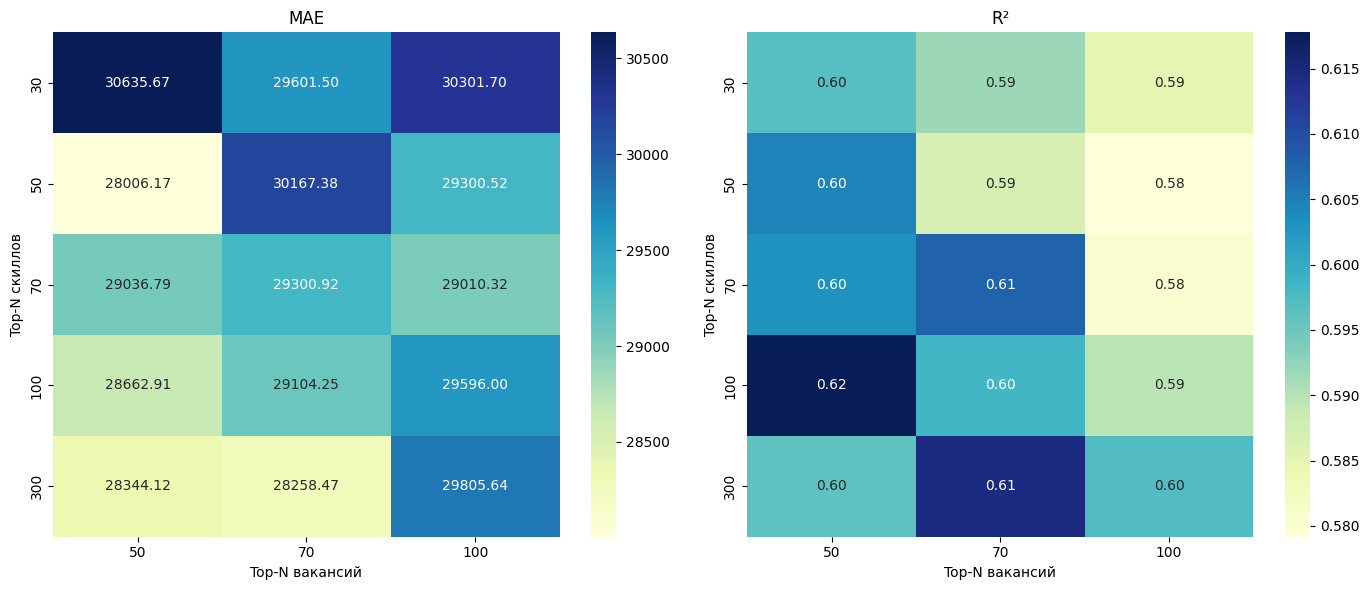

Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 50.0, MAE: 28006.17, R²: 0.60


In [ ]:
# Случайный лес на CPU

# Параметры
top_skills_range = [ 30, 50, 70, 100, 300]
top_vacancies_range = [50,70, 100] # 30, 40 , 50, 70,


results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['skills_normalized'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['skills_normalized'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy'].isin(top_vacancies)]

        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        display(f" Взяли {vac_n} вакансий . Осталось {df_filtered.shape[0]} cтрок в df")
        
        # Удаляем позиции с количеством строк < th
        position_counts = df_filtered['position'].value_counts()
        th = 50
        valid_positions = position_counts[position_counts >= th].index.tolist() # 200

        df_filtered = df_filtered[df_filtered['position'].isin(valid_positions)]

        display(f"После исключения позиций с < {th} строк осталось {df_filtered.shape[0]} строк и {len(valid_positions)} позиций")

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue

        # Целевая переменная после очистки
        y = df_temp['salary from norm']
        
        
        
        if df_temp.empty:
            continue

        X = df_temp[['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills', 'region']] # 'vacancy it',
        #y = df_temp['log_salary']
        #y = df_temp['salary from']

        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        mlb = MultiLabelBinarizer()

        try:
            X_ohe = ohe.fit_transform(X[['position', 'experience', 'schedule', 'employment' ,'vacancy', 'level', 'region']]) # , 'vacancy it',
            X_mlb = mlb.fit_transform(X['skills'])
        except Exception as e:
            print(f"Ошибка кодирования при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        X_final = np.hstack([X_ohe, X_mlb])

        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X_final, df_temp['position']):
                X_train, X_test = X_final[train_idx], X_final[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        rf_model = RandomForestRegressor(
            n_estimators=500, max_depth=100, random_state=42, n_jobs=-1,
            max_features='sqrt', min_samples_leaf=1, min_samples_split=2
        )

        rf_model.fit(X_train, y_train)
        y_pred = rf_model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")


1. вариант с Мэпингом от ОК . На входе вакансии , скилы , професии

Лучшее сочетание по MAE:
Top Skills: 20.0, Top Vacancies: 40.0, MAE: 27137.96, R²: 0.65

Top-N Skills:   0%|          | 0/7 [00:00<?, ?it/s]

' Взяли 30 скилов . Осталось 8979 cтрок в df. Всего уникальных 358'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 4811 cтрок в df'

'После исключения позиций с < 50 строк осталось 1510 строк и 2 позиций'

0:	learn: 51576.6061814	test: 54223.9236320	best: 54223.9236320 (0)	total: 32.6ms	remaining: 32.5s
100:	learn: 29573.4456132	test: 34278.4899097	best: 34278.4899097 (100)	total: 2.6s	remaining: 23.1s
200:	learn: 26898.0938255	test: 33554.3799437	best: 33554.3799437 (200)	total: 4.68s	remaining: 18.6s
300:	learn: 25500.5249036	test: 33253.1084700	best: 33243.0131265 (298)	total: 6.68s	remaining: 15.5s
400:	learn: 24844.1347830	test: 33202.4326820	best: 33195.9587511 (385)	total: 8.59s	remaining: 12.8s
500:	learn: 24253.5298776	test: 33224.5792180	best: 33187.4421838 (462)	total: 10.5s	remaining: 10.4s
600:	learn: 23902.6293436	test: 33230.1814230	best: 33187.4421838 (462)	total: 12.4s	remaining: 8.25s
700:	learn: 23407.8694060	test: 33294.9737624	best: 33187.4421838 (462)	total: 14.5s	remaining: 6.2s
800:	learn: 22760.2310824	test: 33359.9438978	best: 33187.4421838 (462)	total: 16.7s	remaining: 4.14s
900:	learn: 22307.9615072	test: 33411.4758469	best: 33187.4421838 (462)	total: 18.7s	re

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5210 cтрок в df'

'После исключения позиций с < 50 строк осталось 2190 строк и 3 позиций'

0:	learn: 64365.0894830	test: 64324.1269815	best: 64324.1269815 (0)	total: 32.1ms	remaining: 32s
100:	learn: 36394.9262709	test: 38983.3708642	best: 38983.3708642 (100)	total: 2.69s	remaining: 23.9s
200:	learn: 34020.1000199	test: 38098.8736320	best: 38098.8736320 (200)	total: 4.76s	remaining: 18.9s
300:	learn: 32568.4767101	test: 38090.0523221	best: 37989.2525527 (263)	total: 6.89s	remaining: 16s
400:	learn: 31466.6657811	test: 38215.3389478	best: 37989.2525527 (263)	total: 8.98s	remaining: 13.4s
500:	learn: 30484.1631113	test: 38041.0208972	best: 37989.2525527 (263)	total: 11.1s	remaining: 11s
600:	learn: 29610.5445641	test: 38080.7837545	best: 37989.2525527 (263)	total: 13.1s	remaining: 8.68s
700:	learn: 28936.7102280	test: 38119.0711295	best: 37989.2525527 (263)	total: 15s	remaining: 6.41s
800:	learn: 28252.7706088	test: 38194.0000234	best: 37989.2525527 (263)	total: 17s	remaining: 4.23s
900:	learn: 27656.7674669	test: 38198.9064641	best: 37989.2525527 (263)	total: 19s	remaining: 2

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 5627 cтрок в df'

'После исключения позиций с < 50 строк осталось 2366 строк и 3 позиций'

0:	learn: 65408.1116397	test: 61448.8073120	best: 61448.8073120 (0)	total: 31.1ms	remaining: 31s
100:	learn: 38027.0663139	test: 39333.1369600	best: 39333.1369600 (100)	total: 2.65s	remaining: 23.6s
200:	learn: 35346.6899983	test: 38647.6521351	best: 38647.6521351 (200)	total: 4.8s	remaining: 19.1s
300:	learn: 33887.2049633	test: 38506.6311844	best: 38502.2384786 (283)	total: 6.94s	remaining: 16.1s
400:	learn: 32831.0926143	test: 38392.0867875	best: 38383.3382292 (369)	total: 9.04s	remaining: 13.5s
500:	learn: 32052.2239157	test: 38330.6903580	best: 38316.7842723 (462)	total: 11s	remaining: 11s
600:	learn: 31276.9405192	test: 38353.9323100	best: 38304.8643924 (518)	total: 13.1s	remaining: 8.68s
700:	learn: 30771.9444400	test: 38386.7202002	best: 38304.8643924 (518)	total: 15s	remaining: 6.4s
800:	learn: 30284.4488854	test: 38401.7520168	best: 38304.8643924 (518)	total: 16.9s	remaining: 4.2s
900:	learn: 29874.4550928	test: 38471.4211271	best: 38304.8643924 (518)	total: 18.8s	remaining: 

Top-N Skills:  14%|█▍        | 1/7 [01:06<06:37, 66.21s/it]

' Взяли 50 скилов . Осталось 9865 cтрок в df. Всего уникальных 593'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5249 cтрок в df'

'После исключения позиций с < 50 строк осталось 2303 строк и 3 позиций'

0:	learn: 64789.8528306	test: 66028.0340003	best: 66028.0340003 (0)	total: 30.6ms	remaining: 30.6s
100:	learn: 37056.2010422	test: 37629.6446864	best: 37629.6446864 (100)	total: 2.63s	remaining: 23.4s
200:	learn: 34260.8660990	test: 36993.4038116	best: 36993.4038116 (200)	total: 4.71s	remaining: 18.7s
300:	learn: 32775.8755015	test: 36925.2276653	best: 36920.2429495 (299)	total: 6.76s	remaining: 15.7s
400:	learn: 31711.2514740	test: 36938.1339747	best: 36894.6050147 (326)	total: 8.77s	remaining: 13.1s
500:	learn: 30970.2901111	test: 36917.9321589	best: 36894.6050147 (326)	total: 10.7s	remaining: 10.7s
600:	learn: 30274.8762658	test: 36904.3479635	best: 36894.6050147 (326)	total: 12.8s	remaining: 8.47s
700:	learn: 29792.8760469	test: 36885.6813383	best: 36883.0689789 (699)	total: 14.7s	remaining: 6.27s
800:	learn: 29307.1732851	test: 36904.0604650	best: 36865.7699037 (723)	total: 16.6s	remaining: 4.13s
900:	learn: 28898.1840497	test: 36888.1761155	best: 36865.7699037 (723)	total: 18.6s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5678 cтрок в df'

'После исключения позиций с < 50 строк осталось 2448 строк и 3 позиций'

0:	learn: 64988.3759049	test: 63063.6515819	best: 63063.6515819 (0)	total: 32.7ms	remaining: 32.7s
100:	learn: 36519.0872201	test: 38830.6167948	best: 38811.6776199 (99)	total: 2.74s	remaining: 24.4s
200:	learn: 34074.3860570	test: 38562.6633883	best: 38559.3630360 (193)	total: 4.81s	remaining: 19.1s
300:	learn: 32475.3152724	test: 38429.4747185	best: 38422.5252883 (296)	total: 7.04s	remaining: 16.3s
400:	learn: 31417.4395464	test: 38431.4506890	best: 38392.8433718 (313)	total: 9.01s	remaining: 13.5s
500:	learn: 30586.0237570	test: 38417.4716546	best: 38392.8433718 (313)	total: 10.9s	remaining: 10.9s
600:	learn: 29896.3736393	test: 38505.5125783	best: 38392.8433718 (313)	total: 12.8s	remaining: 8.53s
700:	learn: 29238.7414094	test: 38610.4163651	best: 38392.8433718 (313)	total: 14.7s	remaining: 6.28s
800:	learn: 28602.1401445	test: 38661.2616023	best: 38392.8433718 (313)	total: 16.7s	remaining: 4.16s
900:	learn: 28034.7536873	test: 38704.1753061	best: 38392.8433718 (313)	total: 18.7s	r

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6113 cтрок в df'

'После исключения позиций с < 50 строк осталось 3183 строк и 4 позиций'

0:	learn: 63135.2707905	test: 61897.7981091	best: 61897.7981091 (0)	total: 31.8ms	remaining: 31.7s
100:	learn: 35085.3434191	test: 36290.7935883	best: 36290.7935883 (100)	total: 2.69s	remaining: 24s
200:	learn: 32953.4036018	test: 35784.5516851	best: 35784.5516851 (200)	total: 4.72s	remaining: 18.7s
300:	learn: 31903.3576063	test: 35676.9650650	best: 35676.9650650 (300)	total: 6.75s	remaining: 15.7s
400:	learn: 31161.8876780	test: 35650.1569447	best: 35618.7261854 (358)	total: 8.74s	remaining: 13.1s
500:	learn: 30446.9105555	test: 35590.1414961	best: 35583.4492402 (490)	total: 10.9s	remaining: 10.8s
600:	learn: 29764.1628199	test: 35530.4394677	best: 35517.5594431 (563)	total: 12.8s	remaining: 8.52s
700:	learn: 29242.5496421	test: 35501.6777032	best: 35483.5369549 (688)	total: 14.8s	remaining: 6.3s
800:	learn: 28841.9989966	test: 35599.8714389	best: 35483.5369549 (688)	total: 16.7s	remaining: 4.14s
900:	learn: 28469.8836899	test: 35571.9386120	best: 35483.5369549 (688)	total: 18.8s	rem

Top-N Skills:  29%|██▊       | 2/7 [02:12<05:30, 66.02s/it]

' Взяли 70 скилов . Осталось 10331 cтрок в df. Всего уникальных 888'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5475 cтрок в df'

'После исключения позиций с < 50 строк осталось 2404 строк и 3 позиций'

0:	learn: 65848.3370282	test: 62289.4860381	best: 62289.4860381 (0)	total: 31.1ms	remaining: 31.1s
100:	learn: 37071.0505936	test: 39264.6317990	best: 39264.6317990 (100)	total: 2.64s	remaining: 23.5s
200:	learn: 34566.3120678	test: 38691.4665588	best: 38681.2076415 (190)	total: 4.62s	remaining: 18.4s
300:	learn: 33229.3936735	test: 38489.2945467	best: 38484.0298038 (295)	total: 6.48s	remaining: 15s
400:	learn: 32308.5176797	test: 38555.6519074	best: 38478.9691520 (327)	total: 8.35s	remaining: 12.5s
500:	learn: 31544.6101642	test: 38591.2465167	best: 38478.9691520 (327)	total: 10.2s	remaining: 10.2s
600:	learn: 30940.2995683	test: 38654.4065394	best: 38478.9691520 (327)	total: 12s	remaining: 7.97s
700:	learn: 30504.4064510	test: 38677.6956469	best: 38478.9691520 (327)	total: 13.8s	remaining: 5.9s
800:	learn: 30007.6484465	test: 38729.3354161	best: 38478.9691520 (327)	total: 15.7s	remaining: 3.89s
900:	learn: 29440.7945166	test: 38729.5817415	best: 38478.9691520 (327)	total: 17.5s	remai

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5926 cтрок в df'

'После исключения позиций с < 50 строк осталось 2552 строк и 3 позиций'

0:	learn: 64856.3421849	test: 65136.1707772	best: 65136.1707772 (0)	total: 31.5ms	remaining: 31.4s
100:	learn: 37135.2896436	test: 39968.6388231	best: 39968.6388231 (100)	total: 2.65s	remaining: 23.6s
200:	learn: 34975.8926427	test: 39548.6818191	best: 39548.6818191 (200)	total: 4.67s	remaining: 18.6s
300:	learn: 33712.5276470	test: 39411.5520266	best: 39411.5520266 (300)	total: 6.68s	remaining: 15.5s
400:	learn: 32818.8355052	test: 39407.5685735	best: 39386.7254844 (314)	total: 8.64s	remaining: 12.9s
500:	learn: 32062.1923356	test: 39340.0685712	best: 39334.9859686 (458)	total: 10.6s	remaining: 10.6s
600:	learn: 31544.6911170	test: 39325.3350152	best: 39317.0115517 (562)	total: 12.6s	remaining: 8.38s
700:	learn: 30954.8246687	test: 39297.3180671	best: 39297.3180671 (700)	total: 14.5s	remaining: 6.2s
800:	learn: 30393.2784261	test: 39298.7016993	best: 39265.4212233 (765)	total: 16.4s	remaining: 4.08s
900:	learn: 29752.7412142	test: 39312.1069550	best: 39265.4212233 (765)	total: 18.3s	r

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6375 cтрок в df'

'После исключения позиций с < 50 строк осталось 3300 строк и 4 позиций'

0:	learn: 64572.6485938	test: 57005.9486235	best: 57005.9486235 (0)	total: 31.5ms	remaining: 31.5s
100:	learn: 36529.1838235	test: 34341.7884174	best: 34341.7884174 (100)	total: 2.67s	remaining: 23.8s
200:	learn: 34309.0867967	test: 34388.9479548	best: 34228.5601709 (129)	total: 4.6s	remaining: 18.3s
300:	learn: 33150.8413100	test: 34514.6881989	best: 34228.5601709 (129)	total: 6.46s	remaining: 15s
400:	learn: 32304.2753232	test: 34477.1141452	best: 34228.5601709 (129)	total: 8.42s	remaining: 12.6s
500:	learn: 31415.0242446	test: 34432.8542988	best: 34228.5601709 (129)	total: 10.3s	remaining: 10.3s
600:	learn: 30771.1656021	test: 34312.0508578	best: 34228.5601709 (129)	total: 12.3s	remaining: 8.15s
700:	learn: 30211.6272923	test: 34256.2084541	best: 34228.5601709 (129)	total: 14.2s	remaining: 6.05s
800:	learn: 29698.2322964	test: 34224.9486401	best: 34211.2472806 (780)	total: 16.3s	remaining: 4.04s
900:	learn: 29277.8812764	test: 34246.0939509	best: 34211.2472806 (780)	total: 18.4s	rem

Top-N Skills:  43%|████▎     | 3/7 [03:16<04:20, 65.18s/it]

' Взяли 100 скилов . Осталось 10739 cтрок в df. Всего уникальных 1262'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5665 cтрок в df'

'После исключения позиций с < 50 строк осталось 2499 строк и 3 позиций'

0:	learn: 63403.4881883	test: 63778.2734156	best: 63778.2734156 (0)	total: 28.2ms	remaining: 28.1s
100:	learn: 36404.0108524	test: 38712.5323798	best: 38712.5323798 (100)	total: 2.79s	remaining: 24.8s
200:	learn: 34117.9422171	test: 38241.8825296	best: 38228.9384132 (193)	total: 5.08s	remaining: 20.2s
300:	learn: 32665.6155588	test: 38085.1693560	best: 38063.8517165 (272)	total: 7.11s	remaining: 16.5s
400:	learn: 31634.4083235	test: 37947.9171737	best: 37941.3832102 (399)	total: 9.12s	remaining: 13.6s
500:	learn: 30719.5646228	test: 37968.0326071	best: 37939.5802362 (402)	total: 11.3s	remaining: 11.3s
600:	learn: 30108.7598508	test: 37967.2732634	best: 37928.7377182 (527)	total: 13.3s	remaining: 8.83s
700:	learn: 29603.4984364	test: 38007.9505971	best: 37928.7377182 (527)	total: 15.3s	remaining: 6.51s
800:	learn: 29221.5749515	test: 38058.6510797	best: 37928.7377182 (527)	total: 17.2s	remaining: 4.28s
900:	learn: 28919.5286133	test: 38074.8135098	best: 37928.7377182 (527)	total: 19.2s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6133 cтрок в df'

'После исключения позиций с < 50 строк осталось 2654 строк и 3 позиций'

0:	learn: 64336.4822709	test: 65850.4868173	best: 65850.4868173 (0)	total: 31.9ms	remaining: 31.9s
100:	learn: 36591.8622630	test: 41258.3098797	best: 41258.3098797 (100)	total: 2.74s	remaining: 24.4s
200:	learn: 34302.4353735	test: 40997.3775818	best: 40972.6493878 (187)	total: 4.8s	remaining: 19.1s
300:	learn: 33001.0049140	test: 40990.7501432	best: 40908.2953354 (239)	total: 6.82s	remaining: 15.8s
400:	learn: 32103.5194242	test: 41034.5956753	best: 40908.2953354 (239)	total: 8.74s	remaining: 13.1s
500:	learn: 31501.0781799	test: 41159.0016389	best: 40908.2953354 (239)	total: 10.6s	remaining: 10.6s
600:	learn: 30793.1124866	test: 41213.4808016	best: 40908.2953354 (239)	total: 12.6s	remaining: 8.39s
700:	learn: 30209.1595336	test: 41249.3412657	best: 40908.2953354 (239)	total: 14.5s	remaining: 6.2s
800:	learn: 29781.6147271	test: 41308.6403720	best: 40908.2953354 (239)	total: 16.5s	remaining: 4.1s
900:	learn: 29299.7079750	test: 41374.5004040	best: 40908.2953354 (239)	total: 18.7s	rem

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6597 cтрок в df'

'После исключения позиций с < 50 строк осталось 3406 строк и 4 позиций'

0:	learn: 63037.4153593	test: 61370.2184945	best: 61370.2184945 (0)	total: 31.7ms	remaining: 31.7s
100:	learn: 36394.1291158	test: 35007.3646795	best: 34999.4640160 (99)	total: 2.78s	remaining: 24.7s
200:	learn: 33987.2661870	test: 34605.0408933	best: 34605.0408933 (200)	total: 4.96s	remaining: 19.7s
300:	learn: 32690.9388315	test: 34561.6376716	best: 34531.3218100 (279)	total: 7.04s	remaining: 16.4s
400:	learn: 31615.7362540	test: 34528.5385305	best: 34477.8996777 (363)	total: 9.15s	remaining: 13.7s
500:	learn: 30854.1223211	test: 34510.5889094	best: 34477.8996777 (363)	total: 11.3s	remaining: 11.2s
600:	learn: 30031.7773919	test: 34635.3697776	best: 34477.8996777 (363)	total: 13.5s	remaining: 8.99s
700:	learn: 29415.5804929	test: 34693.0399933	best: 34477.8996777 (363)	total: 15.8s	remaining: 6.72s
800:	learn: 28833.4723712	test: 34781.8849252	best: 34477.8996777 (363)	total: 17.9s	remaining: 4.45s
900:	learn: 28369.1815790	test: 34832.9132233	best: 34477.8996777 (363)	total: 20.1s	r

Top-N Skills:  57%|█████▋    | 4/7 [04:24<03:19, 66.42s/it]

' Взяли 300 скилов . Осталось 11260 cтрок в df. Всего уникальных 3945'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5876 cтрок в df'

'После исключения позиций с < 50 строк осталось 2626 строк и 3 позиций'

0:	learn: 63508.1616072	test: 63740.6545618	best: 63740.6545618 (0)	total: 33.5ms	remaining: 33.4s
100:	learn: 36236.0695787	test: 39239.8639513	best: 39239.8639513 (100)	total: 2.63s	remaining: 23.5s
200:	learn: 33933.7531818	test: 38781.6060867	best: 38744.0029132 (179)	total: 4.71s	remaining: 18.7s
300:	learn: 32492.2073027	test: 38437.1698141	best: 38437.1698141 (300)	total: 6.67s	remaining: 15.5s
400:	learn: 31636.8465913	test: 38311.7721322	best: 38308.7171362 (398)	total: 8.58s	remaining: 12.8s
500:	learn: 30924.0324745	test: 38274.6763213	best: 38270.5713352 (484)	total: 10.5s	remaining: 10.5s
600:	learn: 30286.5999130	test: 38176.7135095	best: 38164.2491386 (592)	total: 12.4s	remaining: 8.23s
700:	learn: 29769.0244934	test: 38111.4450327	best: 38109.3171492 (697)	total: 14.3s	remaining: 6.1s
800:	learn: 29216.7580011	test: 38063.7215679	best: 38056.5386133 (799)	total: 16.1s	remaining: 4s
900:	learn: 28891.1098821	test: 38016.2088058	best: 38006.0661988 (879)	total: 18s	remain

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6368 cтрок в df'

'После исключения позиций с < 50 строк осталось 2789 строк и 3 позиций'

0:	learn: 63441.3846166	test: 63695.7767934	best: 63695.7767934 (0)	total: 32.5ms	remaining: 32.4s
100:	learn: 36699.8303738	test: 37313.5043956	best: 37309.9065657 (99)	total: 2.65s	remaining: 23.5s
200:	learn: 34435.6198837	test: 36566.0824789	best: 36559.4230305 (198)	total: 4.67s	remaining: 18.6s
300:	learn: 33108.9869071	test: 36629.5806943	best: 36549.7260653 (275)	total: 6.77s	remaining: 15.7s
400:	learn: 32136.9123503	test: 36715.3271266	best: 36549.7260653 (275)	total: 8.79s	remaining: 13.1s
500:	learn: 31357.8512983	test: 36782.2971320	best: 36549.7260653 (275)	total: 10.9s	remaining: 10.9s
600:	learn: 30715.6345916	test: 36908.2200312	best: 36549.7260653 (275)	total: 12.9s	remaining: 8.59s
700:	learn: 30100.6796910	test: 37044.5408703	best: 36549.7260653 (275)	total: 15s	remaining: 6.4s
800:	learn: 29542.7996689	test: 37125.8437887	best: 36549.7260653 (275)	total: 16.9s	remaining: 4.21s
900:	learn: 28996.2809175	test: 37233.8719538	best: 36549.7260653 (275)	total: 18.9s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6852 cтрок в df'

'После исключения позиций с < 50 строк осталось 3548 строк и 4 позиций'

0:	learn: 62305.3005757	test: 62509.7574792	best: 62509.7574792 (0)	total: 32.8ms	remaining: 32.8s
100:	learn: 35814.3215518	test: 37822.2502859	best: 37822.2502859 (100)	total: 2.67s	remaining: 23.7s
200:	learn: 33684.1197196	test: 37451.1013774	best: 37448.1914165 (198)	total: 4.76s	remaining: 18.9s
300:	learn: 32516.4319670	test: 37577.3619291	best: 37447.0713713 (201)	total: 6.62s	remaining: 15.4s
400:	learn: 31679.4349909	test: 37537.5046830	best: 37447.0713713 (201)	total: 8.69s	remaining: 13s
500:	learn: 31111.3770923	test: 37564.3704063	best: 37447.0713713 (201)	total: 10.7s	remaining: 10.7s
600:	learn: 30513.9710186	test: 37530.5205110	best: 37447.0713713 (201)	total: 12.7s	remaining: 8.43s
700:	learn: 30085.9456576	test: 37573.9023643	best: 37447.0713713 (201)	total: 14.6s	remaining: 6.21s
800:	learn: 29849.4492219	test: 37613.5866322	best: 37447.0713713 (201)	total: 16.5s	remaining: 4.1s
900:	learn: 29576.3769200	test: 37643.9161697	best: 37447.0713713 (201)	total: 18.6s	rem

Top-N Skills:  71%|███████▏  | 5/7 [05:30<02:12, 66.09s/it]

' Взяли 500 скилов . Осталось 11378 cтрок в df. Всего уникальных 6497'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5920 cтрок в df'

'После исключения позиций с < 50 строк осталось 2661 строк и 3 позиций'

0:	learn: 63210.3323665	test: 61968.8949446	best: 61968.8949446 (0)	total: 30.1ms	remaining: 30.1s
100:	learn: 36607.7067748	test: 39119.5112178	best: 39079.3128110 (97)	total: 2.57s	remaining: 22.9s
200:	learn: 34619.7343850	test: 38955.2717658	best: 38942.0138331 (168)	total: 4.59s	remaining: 18.3s
300:	learn: 33407.2361739	test: 38980.0284551	best: 38942.0138331 (168)	total: 6.54s	remaining: 15.2s
400:	learn: 32461.9307344	test: 38917.5442713	best: 38890.5607403 (363)	total: 8.52s	remaining: 12.7s
500:	learn: 31585.6786054	test: 38832.9618744	best: 38824.8235005 (460)	total: 10.5s	remaining: 10.4s
600:	learn: 30867.0381468	test: 38849.9266945	best: 38824.8235005 (460)	total: 12.4s	remaining: 8.26s
700:	learn: 30239.2980275	test: 38912.8727468	best: 38824.8235005 (460)	total: 14.3s	remaining: 6.1s
800:	learn: 29784.9111575	test: 39003.6637635	best: 38824.8235005 (460)	total: 16.2s	remaining: 4.02s
900:	learn: 29398.6732424	test: 39017.2723996	best: 38824.8235005 (460)	total: 18.1s	re

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6418 cтрок в df'

'После исключения позиций с < 50 строк осталось 2826 строк и 3 позиций'

0:	learn: 62594.8824714	test: 64081.3692125	best: 64081.3692125 (0)	total: 32.3ms	remaining: 32.2s
100:	learn: 36437.1732954	test: 39631.4340266	best: 39631.4340266 (100)	total: 2.68s	remaining: 23.9s
200:	learn: 34333.2258574	test: 39030.4410621	best: 39009.6801716 (198)	total: 4.67s	remaining: 18.6s
300:	learn: 33016.0243025	test: 38933.8855421	best: 38933.8855421 (300)	total: 6.67s	remaining: 15.5s
400:	learn: 32174.8667189	test: 38962.0411655	best: 38924.8179534 (333)	total: 8.62s	remaining: 12.9s
500:	learn: 31435.4762030	test: 38895.7594838	best: 38893.8160058 (497)	total: 10.5s	remaining: 10.5s
600:	learn: 30890.6704996	test: 38892.4990086	best: 38852.8252316 (531)	total: 12.4s	remaining: 8.21s
700:	learn: 30437.9142717	test: 38957.6232635	best: 38852.8252316 (531)	total: 14.2s	remaining: 6.07s
800:	learn: 29983.5537282	test: 39025.7823433	best: 38852.8252316 (531)	total: 16.1s	remaining: 3.99s
900:	learn: 29541.2295507	test: 39137.5367720	best: 38852.8252316 (531)	total: 18s	re

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6905 cтрок в df'

'После исключения позиций с < 50 строк осталось 3586 строк и 4 позиций'

0:	learn: 60992.3828378	test: 61811.8530015	best: 61811.8530015 (0)	total: 30.1ms	remaining: 30.1s
100:	learn: 35149.0797116	test: 37044.0351657	best: 37044.0351657 (100)	total: 2.67s	remaining: 23.8s
200:	learn: 33069.0879052	test: 36630.6660028	best: 36625.5833788 (199)	total: 4.58s	remaining: 18.2s
300:	learn: 31890.6401551	test: 36488.3991629	best: 36455.2716568 (252)	total: 6.46s	remaining: 15s
400:	learn: 31034.7164568	test: 36451.8371788	best: 36443.9082573 (367)	total: 8.33s	remaining: 12.4s
500:	learn: 30247.5237427	test: 36436.1950867	best: 36398.0209163 (485)	total: 10.2s	remaining: 10.2s
600:	learn: 29712.2103749	test: 36481.2793068	best: 36398.0209163 (485)	total: 12.1s	remaining: 8.05s
700:	learn: 29213.5025255	test: 36498.4959126	best: 36398.0209163 (485)	total: 14s	remaining: 5.98s
800:	learn: 28784.7219895	test: 36476.6576193	best: 36398.0209163 (485)	total: 15.9s	remaining: 3.95s
900:	learn: 28430.0141263	test: 36470.8557230	best: 36398.0209163 (485)	total: 17.8s	rema

Top-N Skills:  86%|████████▌ | 6/7 [06:34<01:05, 65.38s/it]

' Взяли 800 скилов . Осталось 11434 cтрок в df. Всего уникальных 9693'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5937 cтрок в df'

'После исключения позиций с < 50 строк осталось 2668 строк и 3 позиций'

0:	learn: 64076.9685945	test: 60177.2730338	best: 60177.2730338 (0)	total: 30.3ms	remaining: 30.3s
100:	learn: 36095.9172336	test: 38204.0406284	best: 38204.0406284 (100)	total: 2.69s	remaining: 23.9s
200:	learn: 33842.2614999	test: 37613.5134491	best: 37613.5134491 (200)	total: 4.72s	remaining: 18.8s
300:	learn: 32590.1143637	test: 37252.4767519	best: 37252.4767519 (300)	total: 6.7s	remaining: 15.6s
400:	learn: 31648.6370524	test: 37174.2287826	best: 37143.7112496 (387)	total: 8.6s	remaining: 12.8s
500:	learn: 30837.2382603	test: 37064.4228417	best: 37064.4228417 (500)	total: 10.6s	remaining: 10.6s
600:	learn: 30258.9698768	test: 36981.4818203	best: 36981.4818203 (600)	total: 12.5s	remaining: 8.29s
700:	learn: 29762.4901624	test: 36948.5974287	best: 36937.2118223 (690)	total: 14.3s	remaining: 6.11s
800:	learn: 29267.4374997	test: 36941.9103910	best: 36916.2447170 (766)	total: 16.2s	remaining: 4.02s
900:	learn: 28822.5654557	test: 36931.7433646	best: 36916.2447170 (766)	total: 18s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6439 cтрок в df'

'После исключения позиций с < 50 строк осталось 2834 строк и 3 позиций'

0:	learn: 62802.9450072	test: 66029.6595693	best: 66029.6595693 (0)	total: 31.6ms	remaining: 31.6s
100:	learn: 36450.0483378	test: 40056.6203102	best: 40056.6203102 (100)	total: 2.61s	remaining: 23.2s
200:	learn: 34151.1017541	test: 39441.9384216	best: 39423.5627759 (198)	total: 4.54s	remaining: 18.1s
300:	learn: 32738.1698754	test: 39206.0191209	best: 39191.6414963 (278)	total: 6.42s	remaining: 14.9s
400:	learn: 31733.7295987	test: 39154.3506568	best: 39143.5897698 (374)	total: 8.36s	remaining: 12.5s
500:	learn: 30883.1886228	test: 39128.0029527	best: 39092.5626435 (467)	total: 10.3s	remaining: 10.3s
600:	learn: 30125.6988848	test: 39161.6115699	best: 39092.5626435 (467)	total: 12.3s	remaining: 8.13s
700:	learn: 29452.4390362	test: 39155.4820235	best: 39092.5626435 (467)	total: 14.2s	remaining: 6.07s
800:	learn: 28915.0061860	test: 39277.7683892	best: 39092.5626435 (467)	total: 16.2s	remaining: 4.03s
900:	learn: 28461.8112802	test: 39351.2242089	best: 39092.5626435 (467)	total: 18.2s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\1502167267.py:35: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6927 cтрок в df'

'После исключения позиций с < 50 строк осталось 3594 строк и 4 позиций'

0:	learn: 61683.2062609	test: 59940.3396854	best: 59940.3396854 (0)	total: 31.7ms	remaining: 31.7s
100:	learn: 34730.9643886	test: 38162.0764260	best: 38162.0764260 (100)	total: 2.79s	remaining: 24.9s
200:	learn: 33027.1466939	test: 37905.9592706	best: 37904.0946653 (199)	total: 4.86s	remaining: 19.3s
300:	learn: 31939.8082585	test: 37758.1563514	best: 37742.2360111 (289)	total: 6.82s	remaining: 15.8s
400:	learn: 31164.7470758	test: 37700.2861965	best: 37699.3153409 (399)	total: 8.75s	remaining: 13.1s
500:	learn: 30393.8157198	test: 37595.1509205	best: 37589.7878869 (486)	total: 10.7s	remaining: 10.7s
600:	learn: 29673.1072351	test: 37512.9938143	best: 37504.0258626 (574)	total: 12.7s	remaining: 8.44s
700:	learn: 29123.6332051	test: 37463.5362089	best: 37451.2177691 (688)	total: 14.7s	remaining: 6.25s
800:	learn: 28589.1799776	test: 37380.4470807	best: 37379.3891337 (794)	total: 16.6s	remaining: 4.13s
900:	learn: 28164.0375287	test: 37336.3155160	best: 37332.4341488 (897)	total: 18.6s	

Top-N Skills: 100%|██████████| 7/7 [07:38<00:00, 65.55s/it]


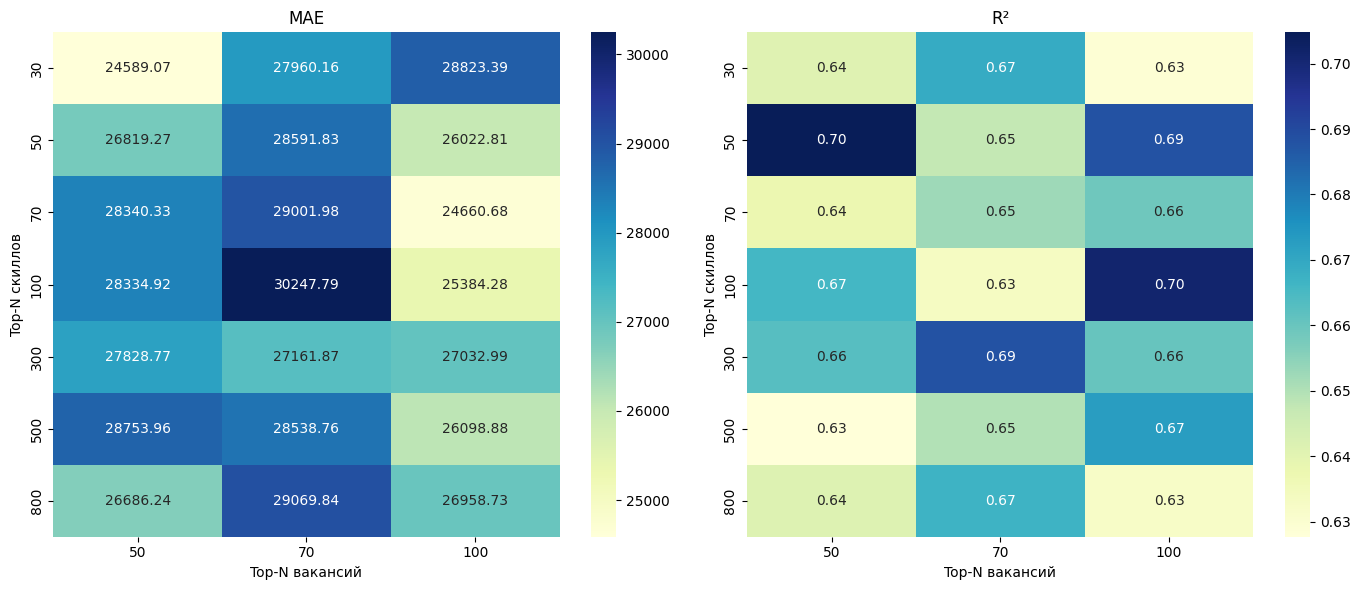

Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 50.0, MAE: 24589.07, R²: 0.64


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

# Параметры
top_skills_range = [ 30, 50, 70, 100, 300, 500, 800]
top_vacancies_range = [50,70, 100] # 30, 40 , 50, 70,


results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['skills_normalized'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['skills_normalized'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy'].isin(top_vacancies)]

        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        display(f" Взяли {vac_n} вакансий . Осталось {df_filtered.shape[0]} cтрок в df")
        
        # Удаляем позиции с количеством строк < th
        position_counts = df_filtered['position'].value_counts()
        th = 200
        valid_positions = position_counts[position_counts >= th].index.tolist() # 200

        df_filtered = df_filtered[df_filtered['position'].isin(valid_positions)]

        display(f"После исключения позиций с < {th} строк осталось {df_filtered.shape[0]} строк и {len(valid_positions)} позиций")

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue



        # 1. Подготовка данных
        y = df_temp['salary from norm']

        if df_temp.empty:
            continue

        # Преобразование skills в строки с явным указанием типа
        df_temp['skills_str'] = df_temp['skills'].apply(
            lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
        )

        # 2. Формирование признаков
        features = ['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills_str', 'region']
        X = df_temp[features]

        # 3. Указываем типы признаков
        cat_features = ['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'region']
        text_features = ['skills_str']

        # 4. Разбиение на train/test
        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X, df_temp['position']):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # 5. Создаем Pool с минимальными параметрами
                train_pool = Pool(
                    data=X_train,
                    label=y_train,
                    cat_features=cat_features,
                    text_features=text_features
                )
                
                test_pool = Pool(
                    data=X_test,
                    label=y_test,
                    cat_features=cat_features,
                    text_features=text_features
                )

        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        # 6. Упрощенная модель без сложной обработки текста
        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            task_type='GPU',
            verbose=100
        )

        # 7. Обучение с базовыми параметрами
        model.fit(train_pool, eval_set=test_pool)

        y_pred = model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")



posiiton > 550 vac
Лучшее сочетание по MAE:
Top Skills: 30.0, Top Vacancies: 50.0, MAE: 24589.07, R²: 0.64

posiiton > 50 vac
Лучшее сочетание по MAE:
Top Skills: 70.0, Top Vacancies: 100.0, MAE: 25800.61, R²: 0.68

#### Перезагрузка DF . Далее использую свои Скилс и Position hh.ru

In [57]:
#df_copy = pd.read_csv('data/stage_3_df_100s_50p_5.csv')
df_copy = pd.read_csv('data/stage_3_df_cluster_vac_to_model_4.csv')


In [58]:
df_copy = df_copy.drop(['industry','level_copy', 'is_it','skills_list', 'skills_clean',
                        'skills_llm','vacancy_info','experience level','contact', 'contacts', 'education', 'benefits', 
                        'requirements', 'responsibilities', 'period of pay', 'text',
                        'ID', 'url', 'skills_count','currency', 'skills_new', 'vacancy_norm'], axis = 1)

In [59]:
# подготовка данных к обучению

df_train_result = df_copy[(df_copy['country'] == 'Россия') ][['salary from norm',
                                                              'salary to norm', 
                                                              'position', 
                                                              'experience_norm', 
                                                               'skills_processed', # 'skills_clean_norm','skills_processed, 'skills_manu'
                                                              'schedule','employment', 'vacancy it',
                                                               #'vacancy_norm_llm_check_1', 'vacancy it','vacancy_manu','vacancy_norm_2', 'vacancy_manu'
                                                              'level',
                                                              'region']]

df_train_result = df_train_result.dropna(subset=['salary from norm', 'salary to norm'], how='any') # 

df_train_result.rename(columns={'skills_processed': 'skills',
                                'experience_norm':'experience',
                                'vacancy it':'vacancy'}, inplace=True)

df_train_result['skills'] = df_train_result['skills'].apply(literal_eval)

df_train_result.rename(columns={
    'salary from norm': 'salary from',
    'salary to norm': 'salary to'
}, inplace=True)

In [60]:
mask = df_train_result['region'].value_counts() >= 50 # 100
df_train_result = df_train_result[df_train_result['region'].isin(mask[mask].index)]

In [61]:
df_train_result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14253 entries, 0 to 14974
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   salary from  14253 non-null  float64
 1   salary to    14253 non-null  float64
 2   position     14253 non-null  object 
 3   experience   14253 non-null  object 
 4   skills       14253 non-null  object 
 5   schedule     14253 non-null  object 
 6   employment   14253 non-null  object 
 7   vacancy      14253 non-null  object 
 8   level        14253 non-null  object 
 9   region       14253 non-null  object 
dtypes: float64(2), object(8)
memory usage: 1.2+ MB


In [62]:
def filtered_skills_top_n(df_train_result, n):
    """
    Фильтрует навыки, оставляя только N наиболее популярных навыков для каждой позиции.
    
    :param df_skills_filtered: Входящий DataFrame с колонками 'position' и 'skills'.
    :param n: Число наиболее популярных навыков, которое нужно оставить.
    :return: Отфильтрованный DataFrame с сокращённым списком навыков.
    """
    
    result_df = df_train_result.copy()
    #display(result_df['skills'])
    # Перебираем каждую уникальную должность
    for pos in result_df['position'].unique():
        # Маска для выбора строк с нужной должностью
        mask = result_df['position'] == pos
        
        # Собираем все навыки в один большой список
        skills_lists = result_df.loc[mask, 'skills']
        all_skills = [skill for sublist in skills_lists for skill in sublist]
        
        # Считаем частоту появления каждого навыка
        skill_counts = Counter(all_skills)
        
        # Берём топ-n навыков
        top_n_skills = set([skill for skill, _ in skill_counts.most_common(n)])
        
        # Применяем фильтр к списку навыков
        result_df.loc[mask, 'skills'] = skills_lists.apply(
            lambda skill_list: [s for s in skill_list if s in top_n_skills]
        )
        #display(result_df['skills'])
    return result_df

In [63]:
from scipy.stats import normaltest

# Функция очистки и нормализации
def process_series(series, colname, position):
    series = pd.to_numeric(series, errors='coerce')
    series = series.dropna()
    n_total = len(series)


    stat, p = normaltest(series)
    is_normal = p > 0.05

    if is_normal:
        mu, sigma = series.mean(), series.std()
        mask = (series >= mu - 3 * sigma) & (series <= mu + 3 * sigma)
    else:
        q1 = series.quantile(0.25)
        q3 = series.quantile(0.75)
        iqr = q3 - q1
        mask = (series >= q1 - 1.5 * iqr) & (series <= q3 + 1.5 * iqr)

    n_filtered = mask.sum()
    n_removed = n_total - n_filtered


    return series[mask]

Top-N Skills:   0%|          | 0/7 [00:00<?, ?it/s]

' Взяли 30 скилов . Осталось 9566 cтрок в df. Всего уникальных 590'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 4784 cтрок в df'

'После исключения позиций с < 50 строк осталось 3316 строк и 6 позиций'

0:	learn: 56955.5212784	test: 57075.1990851	best: 57075.1990851 (0)	total: 31.6ms	remaining: 31.5s
100:	learn: 33393.9933526	test: 34105.9784849	best: 34099.4745260 (98)	total: 2.74s	remaining: 24.4s
200:	learn: 32025.9913017	test: 34085.0775106	best: 33989.8629111 (158)	total: 4.93s	remaining: 19.6s
300:	learn: 31275.0276109	test: 34284.7934689	best: 33989.8629111 (158)	total: 7.01s	remaining: 16.3s
400:	learn: 30868.8517248	test: 34433.2614466	best: 33989.8629111 (158)	total: 9.07s	remaining: 13.6s
500:	learn: 30537.7218065	test: 34601.4530404	best: 33989.8629111 (158)	total: 11.3s	remaining: 11.2s
600:	learn: 30286.4738551	test: 34730.5523330	best: 33989.8629111 (158)	total: 13.4s	remaining: 8.92s
700:	learn: 30073.6043138	test: 34760.5059778	best: 33989.8629111 (158)	total: 15.6s	remaining: 6.66s
800:	learn: 29804.7473138	test: 34781.8506772	best: 33989.8629111 (158)	total: 17.7s	remaining: 4.41s
900:	learn: 29597.7996955	test: 34776.1663010	best: 33989.8629111 (158)	total: 19.9s	r

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5394 cтрок в df'

'После исключения позиций с < 50 строк осталось 3878 строк и 7 позиций'

0:	learn: 58181.0977573	test: 55029.8038035	best: 55029.8038035 (0)	total: 28.9ms	remaining: 28.9s
100:	learn: 33990.0607123	test: 32682.8868608	best: 32682.8868608 (100)	total: 2.84s	remaining: 25.3s
200:	learn: 32684.2652876	test: 32293.9005771	best: 32275.8727562 (183)	total: 5.05s	remaining: 20.1s
300:	learn: 32111.4266667	test: 32329.8535701	best: 32275.8727562 (183)	total: 7.14s	remaining: 16.6s
400:	learn: 31767.2916660	test: 32396.7276294	best: 32275.8727562 (183)	total: 9.37s	remaining: 14s
500:	learn: 31525.1945761	test: 32417.2883388	best: 32275.8727562 (183)	total: 11.5s	remaining: 11.5s
600:	learn: 31291.5958535	test: 32462.9546413	best: 32275.8727562 (183)	total: 13.7s	remaining: 9.07s
700:	learn: 30937.8425616	test: 32532.1525452	best: 32275.8727562 (183)	total: 15.7s	remaining: 6.7s
800:	learn: 30436.4064955	test: 32548.6284971	best: 32275.8727562 (183)	total: 17.9s	remaining: 4.45s
900:	learn: 30102.5451138	test: 32559.9585664	best: 32275.8727562 (183)	total: 20.1s	rem

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 5815 cтрок в df'

'После исключения позиций с < 50 строк осталось 4333 строк и 8 позиций'

0:	learn: 61892.8996234	test: 62575.0046837	best: 62575.0046837 (0)	total: 30.4ms	remaining: 30.3s
100:	learn: 35285.7594311	test: 36965.5758202	best: 36965.5758202 (100)	total: 2.81s	remaining: 25s
200:	learn: 34020.8569497	test: 36692.1098480	best: 36673.0018452 (170)	total: 5.11s	remaining: 20.3s
300:	learn: 33153.6928654	test: 36638.7620305	best: 36616.1549544 (254)	total: 7.42s	remaining: 17.2s
400:	learn: 32536.9748886	test: 36694.1991172	best: 36616.1549544 (254)	total: 9.59s	remaining: 14.3s
500:	learn: 31997.9352442	test: 36769.5451413	best: 36616.1549544 (254)	total: 11.8s	remaining: 11.7s
600:	learn: 31598.3288740	test: 36807.1023440	best: 36616.1549544 (254)	total: 13.9s	remaining: 9.25s
700:	learn: 31236.5310555	test: 36798.3953705	best: 36616.1549544 (254)	total: 16.1s	remaining: 6.86s
800:	learn: 30888.9269272	test: 36820.2820873	best: 36616.1549544 (254)	total: 18.2s	remaining: 4.52s
900:	learn: 30609.1946553	test: 36861.7239607	best: 36616.1549544 (254)	total: 20.4s	re

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6306 cтрок в df'

'После исключения позиций с < 50 строк осталось 5061 строк и 10 позиций'

0:	learn: 62084.6122096	test: 62358.0860156	best: 62358.0860156 (0)	total: 29.8ms	remaining: 29.8s
100:	learn: 35692.1383350	test: 38408.3031819	best: 38408.3031819 (100)	total: 2.75s	remaining: 24.5s
200:	learn: 34496.0925638	test: 38015.4929025	best: 38010.3550761 (197)	total: 4.89s	remaining: 19.4s
300:	learn: 33987.0527263	test: 37962.7126206	best: 37962.7126206 (300)	total: 6.78s	remaining: 15.7s
400:	learn: 33478.2591132	test: 37848.7983292	best: 37843.3862922 (395)	total: 8.79s	remaining: 13.1s
500:	learn: 33108.0942052	test: 37758.5085261	best: 37753.9661728 (499)	total: 10.7s	remaining: 10.7s
600:	learn: 32724.5636930	test: 37723.6133715	best: 37716.1000226 (589)	total: 12.7s	remaining: 8.46s
700:	learn: 32545.7717060	test: 37751.8554333	best: 37715.8942748 (616)	total: 14.6s	remaining: 6.22s
800:	learn: 32323.6751174	test: 37809.4939243	best: 37715.8942748 (616)	total: 16.6s	remaining: 4.12s
900:	learn: 32053.8356723	test: 37818.4043878	best: 37715.8942748 (616)	total: 18.5s	

Top-N Skills:  14%|█▍        | 1/7 [01:32<09:12, 92.09s/it]

' Взяли 50 скилов . Осталось 10574 cтрок в df. Всего уникальных 961'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 5258 cтрок в df'

'После исключения позиций с < 50 строк осталось 3901 строк и 7 позиций'

0:	learn: 57168.0375477	test: 56493.2626397	best: 56493.2626397 (0)	total: 29.2ms	remaining: 29.2s
100:	learn: 33484.7573115	test: 34080.1433632	best: 34080.1433632 (100)	total: 2.61s	remaining: 23.3s
200:	learn: 32213.8972435	test: 33665.1173609	best: 33653.7370312 (188)	total: 4.63s	remaining: 18.4s
300:	learn: 31374.6856234	test: 33474.7288871	best: 33474.7288871 (300)	total: 6.67s	remaining: 15.5s
400:	learn: 30799.0248773	test: 33494.5334896	best: 33418.2332877 (326)	total: 8.63s	remaining: 12.9s
500:	learn: 30417.5664042	test: 33541.9087838	best: 33418.2332877 (326)	total: 10.6s	remaining: 10.6s
600:	learn: 30100.3439613	test: 33667.0237685	best: 33418.2332877 (326)	total: 12.5s	remaining: 8.31s
700:	learn: 29806.0964868	test: 33640.3305241	best: 33418.2332877 (326)	total: 14.5s	remaining: 6.18s
800:	learn: 29517.5344834	test: 33638.0022426	best: 33418.2332877 (326)	total: 16.5s	remaining: 4.09s
900:	learn: 29204.9307390	test: 33672.4581980	best: 33418.2332877 (326)	total: 18.4s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 5917 cтрок в df'

'После исключения позиций с < 50 строк осталось 4308 строк и 7 позиций'

0:	learn: 59125.7486781	test: 57022.6607107	best: 57022.6607107 (0)	total: 29.9ms	remaining: 29.8s
100:	learn: 34009.1908911	test: 34324.4965157	best: 34320.9750723 (97)	total: 2.6s	remaining: 23.2s
200:	learn: 32469.7905944	test: 33925.3631216	best: 33925.3631216 (200)	total: 4.67s	remaining: 18.6s
300:	learn: 31522.8838966	test: 33815.3328004	best: 33793.2421885 (288)	total: 6.78s	remaining: 15.7s
400:	learn: 30985.2195233	test: 33833.1189753	best: 33760.2291922 (336)	total: 8.75s	remaining: 13.1s
500:	learn: 30513.9644973	test: 33841.4977772	best: 33760.2291922 (336)	total: 10.7s	remaining: 10.6s
600:	learn: 30110.0311098	test: 33825.7794405	best: 33760.2291922 (336)	total: 12.7s	remaining: 8.41s
700:	learn: 29696.2726306	test: 33849.9583866	best: 33760.2291922 (336)	total: 14.8s	remaining: 6.3s
800:	learn: 29408.2794186	test: 33847.2457349	best: 33760.2291922 (336)	total: 16.7s	remaining: 4.16s
900:	learn: 29162.5759729	test: 33866.7520369	best: 33760.2291922 (336)	total: 18.7s	rem

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6368 cтрок в df'

'После исключения позиций с < 50 строк осталось 4790 строк и 8 позиций'

0:	learn: 62153.4532539	test: 62776.6510268	best: 62776.6510268 (0)	total: 29.9ms	remaining: 29.9s
100:	learn: 36267.0244810	test: 37699.0981385	best: 37699.0981385 (100)	total: 2.82s	remaining: 25.1s
200:	learn: 35167.7947703	test: 37110.6594810	best: 37110.6594810 (200)	total: 5.18s	remaining: 20.6s
300:	learn: 34535.3599001	test: 36915.7913785	best: 36915.7913785 (300)	total: 7.49s	remaining: 17.4s
400:	learn: 34094.9435250	test: 36738.4707748	best: 36737.0504469 (398)	total: 9.7s	remaining: 14.5s
500:	learn: 33661.6874265	test: 36617.1153242	best: 36614.9380596 (497)	total: 11.8s	remaining: 11.8s
600:	learn: 33492.7624556	test: 36611.4072893	best: 36596.5679050 (555)	total: 13.8s	remaining: 9.16s
700:	learn: 33035.5794390	test: 36502.9025794	best: 36502.9025794 (700)	total: 16s	remaining: 6.84s
800:	learn: 32549.9219713	test: 36371.5287610	best: 36370.9027701 (793)	total: 18.3s	remaining: 4.54s
900:	learn: 32124.8946963	test: 36204.8974822	best: 36204.8974822 (900)	total: 20.4s	rem

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 6906 cтрок в df'

'После исключения позиций с < 50 строк осталось 5565 строк и 10 позиций'

0:	learn: 62519.2852887	test: 65009.9248571	best: 65009.9248571 (0)	total: 30.9ms	remaining: 30.9s
100:	learn: 36633.3313889	test: 38027.0125733	best: 38025.4785384 (99)	total: 2.81s	remaining: 25s
200:	learn: 35263.9134200	test: 37477.6813538	best: 37476.2280734 (199)	total: 5.12s	remaining: 20.4s
300:	learn: 34371.1294662	test: 37317.5195011	best: 37309.2960074 (287)	total: 7.43s	remaining: 17.3s
400:	learn: 33806.1743010	test: 37308.0531530	best: 37271.4333871 (358)	total: 9.61s	remaining: 14.4s
500:	learn: 33441.7763738	test: 37311.1482463	best: 37271.4333871 (358)	total: 11.8s	remaining: 11.7s
600:	learn: 33251.2639400	test: 37306.6858058	best: 37271.4333871 (358)	total: 14s	remaining: 9.31s
700:	learn: 33024.4037958	test: 37311.3285196	best: 37271.4333871 (358)	total: 16.2s	remaining: 6.92s
800:	learn: 32647.8962305	test: 37250.6724386	best: 37249.6705213 (798)	total: 18.3s	remaining: 4.56s
900:	learn: 32387.4029716	test: 37220.5568101	best: 37218.7096587 (897)	total: 20.5s	remai

Top-N Skills:  29%|██▊       | 2/7 [03:02<07:36, 91.39s/it]

' Взяли 70 скилов . Осталось 11151 cтрок в df. Всего уникальных 1337'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 5490 cтрок в df'

'После исключения позиций с < 50 строк осталось 4089 строк и 7 позиций'

0:	learn: 57255.0587338	test: 55721.2100853	best: 55721.2100853 (0)	total: 29.6ms	remaining: 29.6s
100:	learn: 34059.7984064	test: 34675.4566663	best: 34675.4566663 (100)	total: 2.73s	remaining: 24.3s
200:	learn: 32753.4270924	test: 34542.3197046	best: 34499.1702868 (127)	total: 4.74s	remaining: 18.8s
300:	learn: 32115.7174217	test: 34612.5629599	best: 34499.1702868 (127)	total: 6.62s	remaining: 15.4s
400:	learn: 31587.7022480	test: 34637.9746750	best: 34499.1702868 (127)	total: 8.52s	remaining: 12.7s
500:	learn: 31278.1582865	test: 34710.1732473	best: 34499.1702868 (127)	total: 10.4s	remaining: 10.4s
600:	learn: 30927.0719346	test: 34737.8910577	best: 34499.1702868 (127)	total: 12.4s	remaining: 8.21s
700:	learn: 30455.9071616	test: 34758.8744373	best: 34499.1702868 (127)	total: 14.4s	remaining: 6.14s
800:	learn: 30069.8746870	test: 34778.9250629	best: 34499.1702868 (127)	total: 16.5s	remaining: 4.09s
900:	learn: 29721.0870690	test: 34834.5597879	best: 34499.1702868 (127)	total: 18.5s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 6168 cтрок в df'

'После исключения позиций с < 50 строк осталось 4513 строк и 7 позиций'

0:	learn: 57785.3466556	test: 59284.9059912	best: 59284.9059912 (0)	total: 34.2ms	remaining: 34.2s
100:	learn: 33861.4182239	test: 36056.5388247	best: 36056.5388247 (100)	total: 2.93s	remaining: 26s
200:	learn: 32354.6864349	test: 35469.6932183	best: 35469.6932183 (200)	total: 5.18s	remaining: 20.6s
300:	learn: 31574.3127244	test: 35312.9611670	best: 35297.1121983 (271)	total: 7.29s	remaining: 16.9s
400:	learn: 30978.0422719	test: 35280.3875896	best: 35248.8466449 (377)	total: 9.37s	remaining: 14s
500:	learn: 30555.2533976	test: 35293.2885270	best: 35248.8466449 (377)	total: 11.4s	remaining: 11.4s
600:	learn: 30188.9672723	test: 35384.5779807	best: 35248.8466449 (377)	total: 13.5s	remaining: 8.97s
700:	learn: 29932.6330626	test: 35350.6727492	best: 35248.8466449 (377)	total: 15.5s	remaining: 6.63s
800:	learn: 29623.7671218	test: 35365.1089348	best: 35248.8466449 (377)	total: 17.6s	remaining: 4.37s
900:	learn: 29431.7481286	test: 35384.4391760	best: 35248.8466449 (377)	total: 19.6s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6634 cтрок в df'

'После исключения позиций с < 50 строк осталось 5014 строк и 8 позиций'

0:	learn: 61856.3263910	test: 62696.0107338	best: 62696.0107338 (0)	total: 31.1ms	remaining: 31.1s
100:	learn: 35704.4506213	test: 37813.0640299	best: 37813.0640299 (100)	total: 2.88s	remaining: 25.6s
200:	learn: 34406.1977994	test: 37344.8411652	best: 37344.8411652 (200)	total: 5.11s	remaining: 20.3s
300:	learn: 33812.0744272	test: 37251.9716449	best: 37251.9716449 (300)	total: 7.14s	remaining: 16.6s
400:	learn: 33272.3817198	test: 37205.0224731	best: 37198.4043267 (388)	total: 9.27s	remaining: 13.8s
500:	learn: 32870.9345131	test: 37147.2806674	best: 37125.6622286 (459)	total: 11.3s	remaining: 11.3s
600:	learn: 32560.8580283	test: 37061.7037345	best: 37061.7037345 (600)	total: 13.5s	remaining: 8.96s
700:	learn: 32302.1303763	test: 37009.8516208	best: 37007.7841737 (680)	total: 15.5s	remaining: 6.59s
800:	learn: 32012.6740466	test: 36953.1291625	best: 36953.1291625 (800)	total: 17.5s	remaining: 4.34s
900:	learn: 31626.3626088	test: 36924.7854049	best: 36919.6342160 (897)	total: 19.5s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 7210 cтрок в df'

'После исключения позиций с < 50 строк осталось 5823 строк и 10 позиций'

0:	learn: 63217.7064190	test: 62274.0971487	best: 62274.0971487 (0)	total: 32ms	remaining: 31.9s
100:	learn: 37459.5213418	test: 36622.8872788	best: 36622.8393324 (99)	total: 2.84s	remaining: 25.3s
200:	learn: 36059.8832324	test: 36209.6149258	best: 36204.6885803 (188)	total: 5s	remaining: 19.9s
300:	learn: 35250.6761782	test: 36158.6138069	best: 36118.1468559 (238)	total: 7.13s	remaining: 16.6s
400:	learn: 34773.1773022	test: 36141.0285231	best: 36118.1468559 (238)	total: 9.14s	remaining: 13.7s
500:	learn: 34241.1301706	test: 36205.8478727	best: 36118.1468559 (238)	total: 11.2s	remaining: 11.1s
600:	learn: 33919.7075243	test: 36287.7648353	best: 36118.1468559 (238)	total: 13.2s	remaining: 8.76s
700:	learn: 33586.6026051	test: 36347.3391780	best: 36118.1468559 (238)	total: 15.2s	remaining: 6.47s
800:	learn: 33258.7289162	test: 36432.6555292	best: 36118.1468559 (238)	total: 17.2s	remaining: 4.27s
900:	learn: 33010.0586001	test: 36474.3482619	best: 36118.1468559 (238)	total: 19.2s	remain

Top-N Skills:  43%|████▎     | 3/7 [04:33<06:03, 90.94s/it]

' Взяли 100 скилов . Осталось 11658 cтрок в df. Всего уникальных 1870'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 5713 cтрок в df'

'После исключения позиций с < 50 строк осталось 4271 строк и 7 позиций'

0:	learn: 57520.1245983	test: 53346.9820084	best: 53346.9820084 (0)	total: 31.3ms	remaining: 31.3s
100:	learn: 33525.6274710	test: 33519.6817142	best: 33519.6817142 (100)	total: 2.76s	remaining: 24.6s
200:	learn: 32097.0236213	test: 33444.4189284	best: 33439.4895083 (198)	total: 4.93s	remaining: 19.6s
300:	learn: 31384.5322633	test: 33424.8595036	best: 33404.3739384 (216)	total: 6.94s	remaining: 16.1s
400:	learn: 30949.4168631	test: 33434.8635979	best: 33394.3037422 (343)	total: 8.87s	remaining: 13.3s
500:	learn: 30498.2972211	test: 33593.7681244	best: 33394.3037422 (343)	total: 10.9s	remaining: 10.8s
600:	learn: 30179.7686247	test: 33665.5799820	best: 33394.3037422 (343)	total: 12.9s	remaining: 8.54s
700:	learn: 29891.2036455	test: 33666.1958089	best: 33394.3037422 (343)	total: 14.8s	remaining: 6.33s
800:	learn: 29606.7249822	test: 33771.5359550	best: 33394.3037422 (343)	total: 16.8s	remaining: 4.17s
900:	learn: 29323.3587092	test: 33770.6875201	best: 33394.3037422 (343)	total: 18.8s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 6411 cтрок в df'

'После исключения позиций с < 50 строк осталось 4911 строк и 8 позиций'

0:	learn: 60138.1451686	test: 63008.3010266	best: 63008.3010266 (0)	total: 32.5ms	remaining: 32.5s
100:	learn: 35132.0955483	test: 37543.6861738	best: 37543.6861738 (100)	total: 2.8s	remaining: 24.9s
200:	learn: 33761.7229281	test: 37333.5228234	best: 37245.8290751 (156)	total: 4.99s	remaining: 19.8s
300:	learn: 33217.5721934	test: 37402.3065140	best: 37245.8290751 (156)	total: 6.95s	remaining: 16.1s
400:	learn: 32621.1002474	test: 37390.0715544	best: 37245.8290751 (156)	total: 9.01s	remaining: 13.5s
500:	learn: 32361.5521644	test: 37419.6265317	best: 37245.8290751 (156)	total: 11s	remaining: 11s
600:	learn: 31956.4973579	test: 37440.9858379	best: 37245.8290751 (156)	total: 13.2s	remaining: 8.79s
700:	learn: 31560.4925008	test: 37489.5714233	best: 37245.8290751 (156)	total: 15.4s	remaining: 6.55s
800:	learn: 31243.5752030	test: 37564.1939801	best: 37245.8290751 (156)	total: 17.4s	remaining: 4.32s
900:	learn: 30995.3782817	test: 37661.4026414	best: 37245.8290751 (156)	total: 19.3s	remai

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 6897 cтрок в df'

'После исключения позиций с < 50 строк осталось 5432 строк и 9 позиций'

0:	learn: 62009.8957001	test: 60762.8348632	best: 60762.8348632 (0)	total: 32.9ms	remaining: 32.9s
100:	learn: 36423.1166181	test: 35117.0334125	best: 35117.0334125 (100)	total: 2.92s	remaining: 26s
200:	learn: 35033.2733659	test: 34740.8690531	best: 34735.8860195 (191)	total: 5.11s	remaining: 20.3s
300:	learn: 34171.9977922	test: 34709.5392432	best: 34684.6539498 (265)	total: 7.24s	remaining: 16.8s
400:	learn: 33561.1794044	test: 34750.8819152	best: 34684.6539498 (265)	total: 9.31s	remaining: 13.9s
500:	learn: 33080.1642897	test: 34897.6252992	best: 34684.6539498 (265)	total: 11.4s	remaining: 11.4s
600:	learn: 32633.0616803	test: 34960.2480905	best: 34684.6539498 (265)	total: 13.4s	remaining: 8.9s
700:	learn: 32351.5334111	test: 35015.5923134	best: 34684.6539498 (265)	total: 15.4s	remaining: 6.56s
800:	learn: 32022.8466123	test: 35050.2305681	best: 34684.6539498 (265)	total: 17.4s	remaining: 4.33s
900:	learn: 31696.8862176	test: 35054.1137292	best: 34684.6539498 (265)	total: 19.4s	rem

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 7489 cтрок в df'

'После исключения позиций с < 50 строк осталось 6055 строк и 10 позиций'

0:	learn: 62337.8104236	test: 63406.2789877	best: 63406.2789877 (0)	total: 33.2ms	remaining: 33.2s
100:	learn: 36896.8513455	test: 37395.7412026	best: 37395.7412026 (100)	total: 2.86s	remaining: 25.4s
200:	learn: 35530.3803604	test: 36833.7402569	best: 36832.5654090 (199)	total: 5.06s	remaining: 20.1s
300:	learn: 34758.5995947	test: 36644.5487231	best: 36635.7154570 (292)	total: 7.32s	remaining: 17s
400:	learn: 34247.0458331	test: 36617.2532041	best: 36606.0461807 (318)	total: 9.47s	remaining: 14.2s
500:	learn: 33815.0697845	test: 36628.5340733	best: 36579.9376679 (460)	total: 11.6s	remaining: 11.6s
600:	learn: 33317.4090918	test: 36650.5076723	best: 36579.9376679 (460)	total: 13.8s	remaining: 9.18s
700:	learn: 32944.2095096	test: 36749.5795337	best: 36579.9376679 (460)	total: 15.9s	remaining: 6.79s
800:	learn: 32643.2788535	test: 36805.3486912	best: 36579.9376679 (460)	total: 18.1s	remaining: 4.49s
900:	learn: 32366.0871410	test: 36872.1644706	best: 36579.9376679 (460)	total: 20.2s	re

Top-N Skills:  57%|█████▋    | 4/7 [06:04<04:33, 91.08s/it]

' Взяли 300 скилов . Осталось 12987 cтрок в df. Всего уникальных 5213'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 6252 cтрок в df'

'После исключения позиций с < 50 строк осталось 4736 строк и 7 позиций'

0:	learn: 55836.3478294	test: 55623.0948719	best: 55623.0948719 (0)	total: 32.8ms	remaining: 32.8s
100:	learn: 33228.1769194	test: 33893.6465770	best: 33893.1839259 (97)	total: 2.77s	remaining: 24.6s
200:	learn: 31763.3054494	test: 33509.5806560	best: 33501.8764243 (199)	total: 5.04s	remaining: 20s
300:	learn: 30806.0114914	test: 33347.9746875	best: 33347.7585551 (299)	total: 7.2s	remaining: 16.7s
400:	learn: 30018.7206598	test: 33242.7063410	best: 33237.2072186 (398)	total: 9.26s	remaining: 13.8s
500:	learn: 29413.4363697	test: 33204.5936074	best: 33200.0910573 (488)	total: 11.3s	remaining: 11.3s
600:	learn: 28948.8843371	test: 33260.2638078	best: 33200.0910573 (488)	total: 13.4s	remaining: 8.88s
700:	learn: 28540.5290236	test: 33318.4010869	best: 33200.0910573 (488)	total: 15.4s	remaining: 6.59s
800:	learn: 28278.0758967	test: 33376.1347711	best: 33200.0910573 (488)	total: 17.4s	remaining: 4.32s
900:	learn: 27988.4893990	test: 33437.4901496	best: 33200.0910573 (488)	total: 19.4s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 7001 cтрок в df'

'После исключения позиций с < 50 строк осталось 5415 строк и 8 позиций'

0:	learn: 59690.9969469	test: 60506.8765758	best: 60506.8765758 (0)	total: 33.6ms	remaining: 33.6s
100:	learn: 35095.4177009	test: 37268.1999403	best: 37264.4846447 (98)	total: 2.78s	remaining: 24.7s
200:	learn: 33636.0879251	test: 36714.7851200	best: 36714.7851200 (200)	total: 4.98s	remaining: 19.8s
300:	learn: 32798.0160476	test: 36486.2967939	best: 36484.4771535 (296)	total: 7.16s	remaining: 16.6s
400:	learn: 32323.1914054	test: 36444.9478173	best: 36442.5702062 (394)	total: 9.18s	remaining: 13.7s
500:	learn: 31991.5284727	test: 36439.4958255	best: 36427.1622052 (437)	total: 11.2s	remaining: 11.2s
600:	learn: 31676.9843457	test: 36402.5695944	best: 36400.9150797 (590)	total: 13.3s	remaining: 8.86s
700:	learn: 31293.9106133	test: 36412.7179861	best: 36398.6536203 (626)	total: 15.4s	remaining: 6.56s
800:	learn: 30967.9537697	test: 36417.2239373	best: 36398.6536203 (626)	total: 17.4s	remaining: 4.33s
900:	learn: 30670.8642426	test: 36399.0375251	best: 36398.6536203 (626)	total: 19.5s	r

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 7551 cтрок в df'

'После исключения позиций с < 50 строк осталось 6207 строк и 10 позиций'

0:	learn: 59904.9591551	test: 58876.5572722	best: 58876.5572722 (0)	total: 31.2ms	remaining: 31.2s
100:	learn: 35778.1364161	test: 35595.9346705	best: 35595.9346705 (100)	total: 2.77s	remaining: 24.6s
200:	learn: 34339.1669635	test: 35273.8936450	best: 35271.3764249 (191)	total: 4.98s	remaining: 19.8s
300:	learn: 33509.1944343	test: 35222.1370581	best: 35212.5942529 (288)	total: 7.16s	remaining: 16.6s
400:	learn: 32858.9155092	test: 35269.6319967	best: 35212.5942529 (288)	total: 9.36s	remaining: 14s
500:	learn: 32386.2514084	test: 35297.2038739	best: 35212.5942529 (288)	total: 11.5s	remaining: 11.5s
600:	learn: 31969.4367678	test: 35326.1902745	best: 35212.5942529 (288)	total: 13.7s	remaining: 9.08s
700:	learn: 31603.8851117	test: 35335.0382851	best: 35212.5942529 (288)	total: 15.9s	remaining: 6.78s
800:	learn: 31237.7652491	test: 35325.6939456	best: 35212.5942529 (288)	total: 18s	remaining: 4.48s
900:	learn: 30941.3046375	test: 35344.7219568	best: 35212.5942529 (288)	total: 20.1s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 8180 cтрок в df'

'После исключения позиций с < 50 строк осталось 6877 строк и 11 позиций'

0:	learn: 60845.2594888	test: 62055.4803998	best: 62055.4803998 (0)	total: 31.5ms	remaining: 31.5s
100:	learn: 36594.6065174	test: 37575.2293024	best: 37574.8256263 (99)	total: 2.95s	remaining: 26.2s
200:	learn: 35321.4411644	test: 37359.5133991	best: 37334.0849792 (165)	total: 5.2s	remaining: 20.7s
300:	learn: 34408.2223607	test: 37306.3133834	best: 37306.3133834 (300)	total: 7.48s	remaining: 17.4s
400:	learn: 33679.9611457	test: 37268.7028523	best: 37253.2429153 (335)	total: 9.69s	remaining: 14.5s
500:	learn: 33070.1816626	test: 37216.1778163	best: 37213.4929430 (439)	total: 11.9s	remaining: 11.8s
600:	learn: 32664.9998838	test: 37227.1430278	best: 37210.9437514 (511)	total: 14.1s	remaining: 9.39s
700:	learn: 32344.3332046	test: 37209.2873303	best: 37198.5019669 (678)	total: 16.4s	remaining: 6.99s
800:	learn: 31952.5671987	test: 37243.3792175	best: 37198.5019669 (678)	total: 18.6s	remaining: 4.61s
900:	learn: 31583.1797259	test: 37254.9232326	best: 37198.5019669 (678)	total: 20.7s	re

Top-N Skills:  71%|███████▏  | 5/7 [07:38<03:04, 92.03s/it]

' Взяли 500 скилов . Осталось 13443 cтрок в df. Всего уникальных 8209'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 6436 cтрок в df'

'После исключения позиций с < 50 строк осталось 4898 строк и 7 позиций'

0:	learn: 55661.4996770	test: 54983.2654828	best: 54983.2654828 (0)	total: 29.8ms	remaining: 29.8s
100:	learn: 33049.2802721	test: 32630.5841406	best: 32630.5841406 (100)	total: 2.75s	remaining: 24.4s
200:	learn: 31599.9715613	test: 32486.0130483	best: 32470.9118050 (175)	total: 4.75s	remaining: 18.9s
300:	learn: 30623.4179608	test: 32475.8041865	best: 32437.6116633 (245)	total: 6.76s	remaining: 15.7s
400:	learn: 30041.4450660	test: 32472.7120859	best: 32437.6116633 (245)	total: 8.76s	remaining: 13.1s
500:	learn: 29563.2136238	test: 32511.1679438	best: 32437.6116633 (245)	total: 10.7s	remaining: 10.7s
600:	learn: 29070.6776010	test: 32515.1469683	best: 32437.6116633 (245)	total: 12.8s	remaining: 8.51s
700:	learn: 28680.3860620	test: 32568.4056211	best: 32437.6116633 (245)	total: 14.8s	remaining: 6.33s
800:	learn: 28194.2689235	test: 32588.3664005	best: 32437.6116633 (245)	total: 16.8s	remaining: 4.18s
900:	learn: 27912.2775493	test: 32655.0118473	best: 32437.6116633 (245)	total: 18.9s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 7208 cтрок в df'

'После исключения позиций с < 50 строк осталось 5795 строк и 9 позиций'

0:	learn: 59687.1289469	test: 60505.4371889	best: 60505.4371889 (0)	total: 35.5ms	remaining: 35.5s
100:	learn: 35872.4635422	test: 36198.6674666	best: 36198.6674666 (100)	total: 2.78s	remaining: 24.7s
200:	learn: 34415.3074822	test: 35727.6202367	best: 35719.9451050 (198)	total: 4.86s	remaining: 19.3s
300:	learn: 33640.0027264	test: 35645.2777013	best: 35644.5763713 (297)	total: 6.89s	remaining: 16s
400:	learn: 33102.9583213	test: 35621.9993611	best: 35603.8997461 (340)	total: 8.87s	remaining: 13.3s
500:	learn: 32785.0141783	test: 35669.5471242	best: 35603.8997461 (340)	total: 10.6s	remaining: 10.6s
600:	learn: 32348.6924086	test: 35631.4978980	best: 35603.8997461 (340)	total: 12.7s	remaining: 8.44s
700:	learn: 31959.3845315	test: 35672.3455760	best: 35603.8997461 (340)	total: 14.7s	remaining: 6.28s
800:	learn: 31550.5883209	test: 35749.1842777	best: 35603.8997461 (340)	total: 16.8s	remaining: 4.16s
900:	learn: 31197.0487750	test: 35816.0205745	best: 35603.8997461 (340)	total: 18.8s	re

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 7773 cтрок в df'

'После исключения позиций с < 50 строк осталось 6397 строк и 10 позиций'

0:	learn: 59481.8599928	test: 60224.7821416	best: 60224.7821416 (0)	total: 35.5ms	remaining: 35.5s
100:	learn: 35317.2769070	test: 37331.4639900	best: 37331.4639900 (100)	total: 2.77s	remaining: 24.6s
200:	learn: 33933.5760123	test: 36880.4569711	best: 36850.7755818 (184)	total: 5.12s	remaining: 20.3s
300:	learn: 33222.5913678	test: 36776.1615947	best: 36775.8848293 (299)	total: 7.43s	remaining: 17.3s
400:	learn: 32599.3630507	test: 36687.3924158	best: 36678.5148668 (390)	total: 9.71s	remaining: 14.5s
500:	learn: 32087.0887760	test: 36637.7249904	best: 36636.9198990 (498)	total: 12s	remaining: 11.9s
600:	learn: 31600.6599250	test: 36568.4450673	best: 36567.5404625 (599)	total: 14.3s	remaining: 9.46s
700:	learn: 31187.3183849	test: 36536.1679307	best: 36509.8764972 (649)	total: 16.5s	remaining: 7.03s
800:	learn: 30789.6966706	test: 36538.8811656	best: 36509.8764972 (649)	total: 18.8s	remaining: 4.66s
900:	learn: 30359.4178177	test: 36556.8127280	best: 36509.8764972 (649)	total: 21s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 8424 cтрок в df'

'После исключения позиций с < 50 строк осталось 7087 строк и 11 позиций'

0:	learn: 60203.6391347	test: 61438.3888757	best: 61438.3888757 (0)	total: 31.9ms	remaining: 31.9s
100:	learn: 36113.4194223	test: 36982.4498859	best: 36982.4498859 (100)	total: 2.96s	remaining: 26.3s
200:	learn: 34697.4421137	test: 36552.1582540	best: 36552.1582540 (200)	total: 5.3s	remaining: 21.1s
300:	learn: 33803.0307010	test: 36367.6357181	best: 36363.6873117 (291)	total: 7.52s	remaining: 17.5s
400:	learn: 33027.7854348	test: 36162.4416585	best: 36161.5517763 (396)	total: 9.77s	remaining: 14.6s
500:	learn: 32459.5806885	test: 36163.9507654	best: 36146.6234697 (447)	total: 12s	remaining: 11.9s
600:	learn: 31983.3054933	test: 36158.8585784	best: 36146.6234697 (447)	total: 14.1s	remaining: 9.37s
700:	learn: 31592.1475020	test: 36120.7003003	best: 36119.9578764 (686)	total: 16.3s	remaining: 6.95s
800:	learn: 31234.7723204	test: 36091.4659216	best: 36090.4765214 (778)	total: 18.5s	remaining: 4.6s
900:	learn: 30910.5227664	test: 36056.5480561	best: 36056.3027525 (895)	total: 20.7s	rema

Top-N Skills:  86%|████████▌ | 6/7 [09:11<01:32, 92.49s/it]

' Взяли 800 скилов . Осталось 13723 cтрок в df. Всего уникальных 11882'

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 30 вакансий . Осталось 6547 cтрок в df'

'После исключения позиций с < 50 строк осталось 4996 строк и 7 позиций'

0:	learn: 55497.6308435	test: 55978.9109652	best: 55978.9109652 (0)	total: 32.5ms	remaining: 32.5s
100:	learn: 33284.6309241	test: 33476.3359283	best: 33476.3359283 (100)	total: 2.56s	remaining: 22.8s
200:	learn: 31832.5028296	test: 33130.6919626	best: 33130.6919626 (200)	total: 4.52s	remaining: 18s
300:	learn: 31027.4821566	test: 33200.3319094	best: 33113.7772560 (225)	total: 6.42s	remaining: 14.9s
400:	learn: 30407.1682577	test: 33247.4657735	best: 33113.7772560 (225)	total: 8.31s	remaining: 12.4s
500:	learn: 30016.5131275	test: 33329.2363739	best: 33113.7772560 (225)	total: 10.3s	remaining: 10.3s
600:	learn: 29687.0476487	test: 33436.4980778	best: 33113.7772560 (225)	total: 12.3s	remaining: 8.14s
700:	learn: 29391.4755643	test: 33473.1883698	best: 33113.7772560 (225)	total: 14.2s	remaining: 6.05s
800:	learn: 29114.8966651	test: 33552.2889753	best: 33113.7772560 (225)	total: 16.1s	remaining: 4s
900:	learn: 28924.8849320	test: 33553.1822178	best: 33113.7772560 (225)	total: 18s	remaini

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 50 вакансий . Осталось 7328 cтрок в df'

'После исключения позиций с < 50 строк осталось 5902 строк и 9 позиций'

0:	learn: 59076.9692232	test: 60507.1953197	best: 60507.1953197 (0)	total: 32.1ms	remaining: 32s
100:	learn: 35366.2881730	test: 35717.2866398	best: 35717.2866398 (100)	total: 2.76s	remaining: 24.6s
200:	learn: 33685.3685389	test: 35088.6231827	best: 35086.4438315 (197)	total: 4.97s	remaining: 19.8s
300:	learn: 32710.2638387	test: 35019.1529846	best: 35017.1672461 (251)	total: 7.15s	remaining: 16.6s
400:	learn: 32045.5703313	test: 35029.0719450	best: 35010.7120134 (311)	total: 9.41s	remaining: 14.1s
500:	learn: 31489.3878016	test: 35052.9447704	best: 35007.9290242 (414)	total: 11.5s	remaining: 11.5s
600:	learn: 30928.0648980	test: 35050.1651345	best: 35007.9290242 (414)	total: 13.7s	remaining: 9.08s
700:	learn: 30483.9929482	test: 35128.8101188	best: 35007.9290242 (414)	total: 15.9s	remaining: 6.76s
800:	learn: 30066.3384282	test: 35186.8921925	best: 35007.9290242 (414)	total: 18s	remaining: 4.46s
900:	learn: 29699.8139099	test: 35255.6578592	best: 35007.9290242 (414)	total: 20.1s	rema

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 70 вакансий . Осталось 7901 cтрок в df'

'После исключения позиций с < 50 строк осталось 6506 строк и 10 позиций'

0:	learn: 60131.0234617	test: 57122.3330235	best: 57122.3330235 (0)	total: 32.3ms	remaining: 32.3s
100:	learn: 36019.4763204	test: 33704.8972733	best: 33704.8972733 (100)	total: 2.86s	remaining: 25.4s
200:	learn: 34567.5476226	test: 33217.9437317	best: 33216.2826177 (199)	total: 5.15s	remaining: 20.5s
300:	learn: 33680.4529318	test: 33100.5194212	best: 33096.9777052 (298)	total: 7.39s	remaining: 17.2s
400:	learn: 33038.8555249	test: 33013.2465660	best: 33006.5526329 (362)	total: 9.47s	remaining: 14.1s
500:	learn: 32516.3077350	test: 32981.7255350	best: 32969.8571340 (466)	total: 11.6s	remaining: 11.6s
600:	learn: 32040.9742464	test: 33019.2278582	best: 32948.3970157 (519)	total: 13.7s	remaining: 9.11s
700:	learn: 31632.1493889	test: 33012.3036875	best: 32948.3970157 (519)	total: 15.9s	remaining: 6.77s
800:	learn: 31324.0165649	test: 33075.2000620	best: 32948.3970157 (519)	total: 18.2s	remaining: 4.51s
900:	learn: 31067.4740251	test: 33088.0256687	best: 32948.3970157 (519)	total: 20.3s	

C:\Users\Андрей\AppData\Local\Temp\ipykernel_11772\2943226459.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)


' Взяли 100 вакансий . Осталось 8561 cтрок в df'

'После исключения позиций с < 50 строк осталось 7204 строк и 11 позиций'

0:	learn: 59589.5721670	test: 62335.6144785	best: 62335.6144785 (0)	total: 37.7ms	remaining: 37.7s
100:	learn: 35521.8661579	test: 37368.3684159	best: 37368.3684159 (100)	total: 3.01s	remaining: 26.8s
200:	learn: 33963.3249177	test: 36933.3297022	best: 36933.3297022 (200)	total: 5.25s	remaining: 20.8s
300:	learn: 32984.6662637	test: 36916.7628689	best: 36840.2970519 (222)	total: 7.51s	remaining: 17.4s
400:	learn: 32371.7064742	test: 36991.7760420	best: 36840.2970519 (222)	total: 9.76s	remaining: 14.6s
500:	learn: 31800.1923685	test: 37045.5746541	best: 36840.2970519 (222)	total: 12s	remaining: 11.9s
600:	learn: 31264.9608720	test: 37056.4199931	best: 36840.2970519 (222)	total: 14.2s	remaining: 9.42s
700:	learn: 30851.6130303	test: 37080.6267997	best: 36840.2970519 (222)	total: 16.4s	remaining: 7s
800:	learn: 30492.5124322	test: 37107.9607136	best: 36840.2970519 (222)	total: 18.5s	remaining: 4.6s
900:	learn: 30150.9566388	test: 37082.3641739	best: 36840.2970519 (222)	total: 20.6s	remain

Top-N Skills: 100%|██████████| 7/7 [10:45<00:00, 92.16s/it]


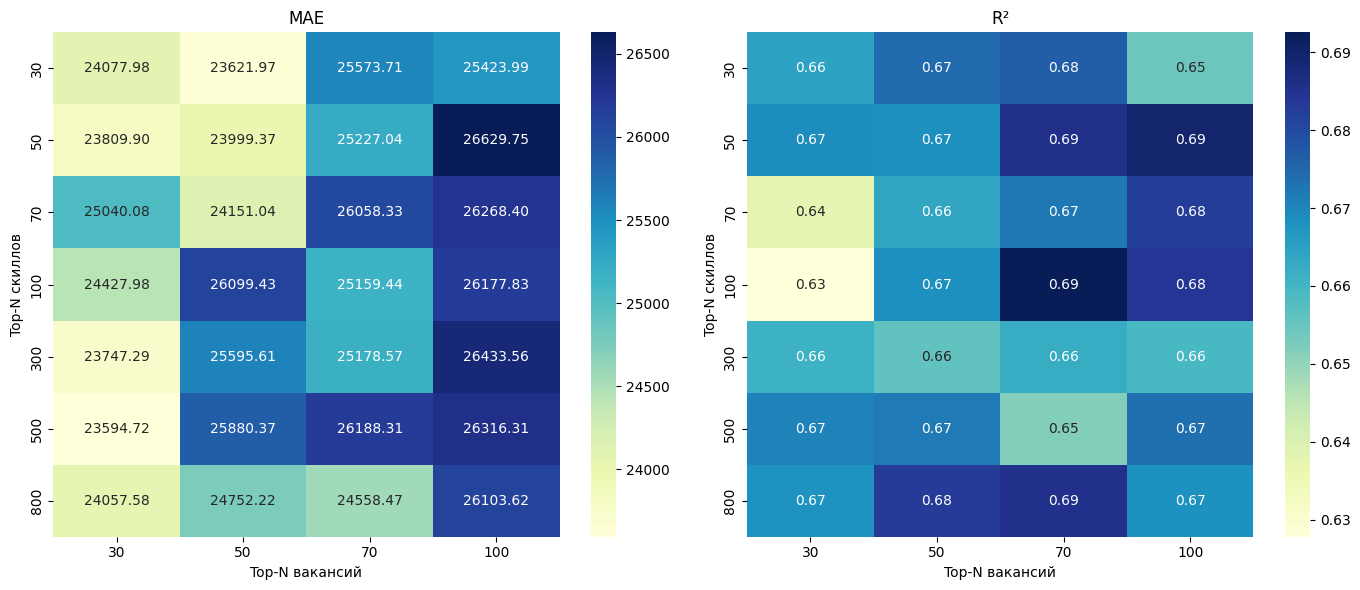

Лучшее сочетание по MAE:
Top Skills: 500.0, Top Vacancies: 30.0, MAE: 23594.72, R²: 0.67


In [ ]:
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import StratifiedShuffleSplit
import pandas as pd

# Параметры
top_skills_range = [ 30, 50, 70, 100, 300, 500, 800]
top_vacancies_range = [30, 50,70, 100] # 30, 40 , 50, 70,


results = []

for skill_n in tqdm(top_skills_range, desc="Top-N Skills"):
    df_skills_filtered = filtered_skills_top_n(df_train_result.copy(), skill_n)
    #display(df_skills_filtered['skills'])
    # Удаляем строки с пустыми списками skills
    df_skills_filtered = df_skills_filtered[df_skills_filtered['skills'].apply(lambda x: len(x) > 0)]
    

    def flatten_skills(skills_series):
        all_skills = []
        for skill_list in skills_series:
            if isinstance(skill_list, list):
                all_skills.extend(skill_list)
        return all_skills
    #display(df_skills_filtered['skills'])
    display(f" Взяли {skill_n} скилов . Осталось {df_skills_filtered.shape[0]} cтрок в df. Всего уникальных {len(set(flatten_skills(df_skills_filtered['skills'])))}" )
    for vac_n in top_vacancies_range:
        # Фильтрация вакансий по top-N внутри позиции
        def filter_top_vacancies(group, n=vac_n):
            vac_counts = group['vacancy'].value_counts()
            top_vacancies = vac_counts.head(n).index.tolist()
            #top_vacancies = vac_counts.index.tolist()
            return group[group['vacancy'].isin(top_vacancies)]
        
        def filter_top_vacancies_2(group, n=vac_n):
            # Считаем частоту вакансий в группе
            vac_counts = group['vacancy'].value_counts()
            
            # Получаем список топ-N вакансий
            top_vacancies = vac_counts.head(n).index.tolist()
            
            # Создаем копию группы, чтобы не изменять оригинал
            group_modified = group.copy()
            
            # Заменяем вакансии не из топа на 'Other'
            group_modified['vacancy'] = group_modified['vacancy'].apply(
                lambda x: x if x in top_vacancies else 'Other'
    )
    
            return group_modified

        df_filtered = df_skills_filtered.groupby('position', group_keys=False).apply(filter_top_vacancies).reset_index(drop=True)
        display(f" Взяли {vac_n} вакансий . Осталось {df_filtered.shape[0]} cтрок в df")
        
        # Удаляем позиции с количеством строк < 50
        position_counts = df_filtered['position'].value_counts()
        th = 200
        valid_positions = position_counts[position_counts >= th].index.tolist() # 200

        df_filtered = df_filtered[df_filtered['position'].isin(valid_positions)]

        display(f"После исключения позиций с < {th} строк осталось {df_filtered.shape[0]} строк и {len(valid_positions)} позиций")

        
        
        
        # Обработка целевой переменной и признаков
        df_temp = df_filtered.copy()
        
        
        # Очистка целевой переменной от выбросов
        positions_temp = df_temp['position'].dropna().unique()

        for pos in positions_temp:
            pos_mask = df_temp['position'] == pos
            clean_series = process_series(df_temp.loc[pos_mask, 'salary from'], 'salary from', pos)
            if clean_series is not None:
                df_temp.loc[clean_series.index, 'salary from norm'] = clean_series

        # Удалим строки с NaN после очистки
        df_temp = df_temp.dropna(subset=['salary from norm'])
        
        
        if df_temp.empty:
            continue



        # 1. Подготовка данных
        y = df_temp['salary from norm']

        if df_temp.empty:
            continue

        # Преобразование skills в строки с явным указанием типа
        df_temp['skills_str'] = df_temp['skills'].apply(
            lambda x: ', '.join(map(str, x)) if isinstance(x, list) else str(x)
        )

        # 2. Формирование признаков
        features = ['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'skills_str', 'region']
        X = df_temp[features]

        # 3. Указываем типы признаков
        cat_features = ['position', 'experience', 'schedule', 'employment', 'level', 'vacancy', 'region']
        text_features = ['skills_str']

        # 4. Разбиение на train/test
        try:
            splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
            for train_idx, test_idx in splitter.split(X, df_temp['position']):
                X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
                y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
                
                # 5. Создаем Pool с минимальными параметрами
                train_pool = Pool(
                    data=X_train,
                    label=y_train,
                    cat_features=cat_features,
                    text_features=text_features
                )
                
                test_pool = Pool(
                    data=X_test,
                    label=y_test,
                    cat_features=cat_features,
                    text_features=text_features
                )

        except ValueError as e:
            print(f"Ошибка split при skill_n={skill_n}, vac_n={vac_n}: {e}")
            continue

        # 6. Упрощенная модель без сложной обработки текста
        model = CatBoostRegressor(
            iterations=1000,
            learning_rate=0.05,
            depth=6,
            task_type='GPU',
            verbose=100
        )

        # 7. Обучение с базовыми параметрами
        model.fit(train_pool, eval_set=test_pool)

        y_pred = model.predict(X_test)
        
        
        #y_pred = np.expm1(y_pred)
        
        #mae = mean_absolute_error(np.expm1(y_test), y_pred)
        #r2 = r2_score(np.expm1(y_test),  y_pred)
        
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test,  y_pred)

        results.append({
            'top_skills': skill_n,
            'top_vacancies': vac_n,
            'mae': mae,
            'r2': r2,
            'rows': len(df_temp)
        })

# Переводим результаты в DataFrame
results_df = pd.DataFrame(results)

# Визуализация результатов
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
pivot_mae = results_df.pivot(index='top_skills', columns='top_vacancies', values='mae')
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('MAE')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.subplot(1, 2, 2)
pivot_r2 = results_df.pivot(index='top_skills', columns='top_vacancies', values='r2')
sns.heatmap(pivot_r2, annot=True, fmt=".2f", cmap="YlGnBu")
plt.title('R²')
plt.xlabel('Top-N вакансий')
plt.ylabel('Top-N скиллов')

plt.tight_layout()
plt.show()

# Вывод лучшего сочетания
best_row = results_df.sort_values(by='mae').iloc[0]
print(f"Лучшее сочетание по MAE:\nTop Skills: {best_row['top_skills']}, "
      f"Top Vacancies: {best_row['top_vacancies']}, "
      f"MAE: {best_row['mae']:.2f}, R²: {best_row['r2']:.2f}")



position > 50 vac  
Лучшее сочетание по MAE:
Top Skills: 50.0, Top Vacancies: 30.0, MAE: 25201.48, R²: 0.67

position > 200 vac 
Лучшее сочетание по MAE:
Top Skills: 500.0, Top Vacancies: 30.0, MAE: 23594.72, R²: 0.67
30/50  mae 23 621 r2 0.67

position > 550 vac  
Лучшее сочетание по MAE:
Top Skills: 800.0, Top Vacancies: 50.0, MAE: 22092.60, R²: 0.70

30 / 100 mae 22 900 r2= 0.75 